In [1]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [67]:
# 기본 세팅
name1 = "AAPL"
name2 = "TSLA"
cut_left = -0.1
cut_right = 0.1
num_bins = 32
num_dataset = 2000

## 금융 데이터를 yfinance로부터 받아오기

In [43]:
import yfinance as yf
import datetime

def get_stocks_datas(ticker_names: list[str], start_date, end_date):
    # WARN: returns는 prices보다 길이가 1 작다.
    prices = {}
    returns = {}
    for name in ticker_names:
        data = yf.Ticker(name)
        data = data.history(start=start_date, end=end_date, interval="1d")
        prices[name] = data['Close']
        returns[name] = data['Close'].pct_change()[1:]
    return prices, returns

start_date = datetime.datetime(2011, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
stock_prices, stock_returns = get_stocks_datas([name1, name2], start_date, end_date)


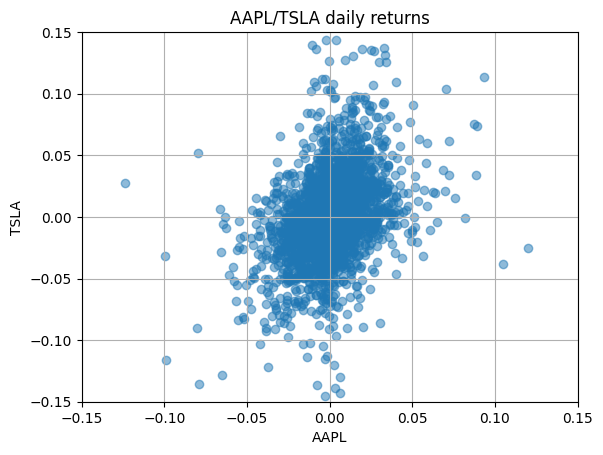

In [44]:
# 산점도 그리기
plt.scatter(stock_returns[name1].values, stock_returns[name2].values, alpha=0.5)
plt.title(f'{name1}/{name2} daily returns')
plt.xlabel(name1)
plt.ylabel(name2)
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0.15)
plt.grid(True)
plt.show()

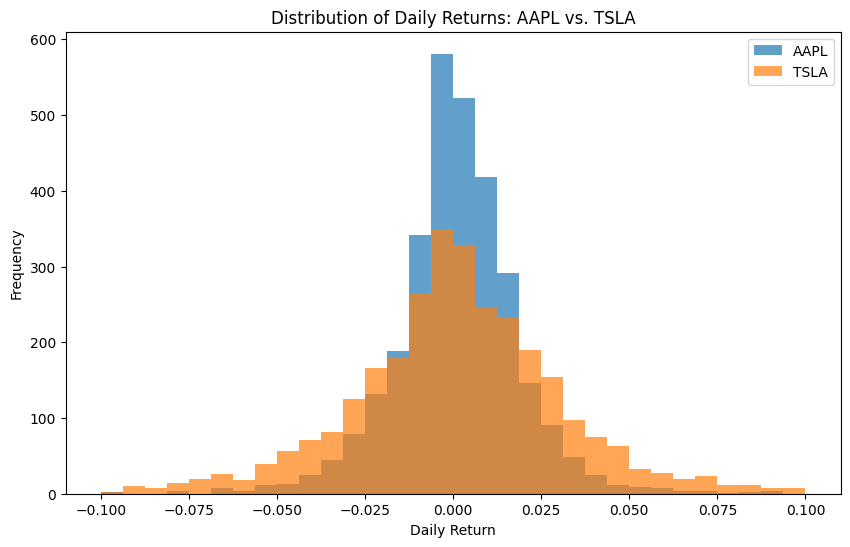

In [58]:
import matplotlib.pyplot as plt
import numpy as np

bin_edges = np.linspace(cut_left, cut_right, num_bins+1)

plt.figure(figsize=(10, 6))

plt.hist(stock_returns[name1].values, bins=bin_edges, alpha=0.7, label=name1)
plt.hist(stock_returns[name2].values, bins=bin_edges, alpha=0.7, label=name2)

plt.title(f'Distribution of Daily Returns: {name1} vs. {name2}')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## risk-return space에 그려보자
앞으로 우리가 뽑을 최종 결과물이다

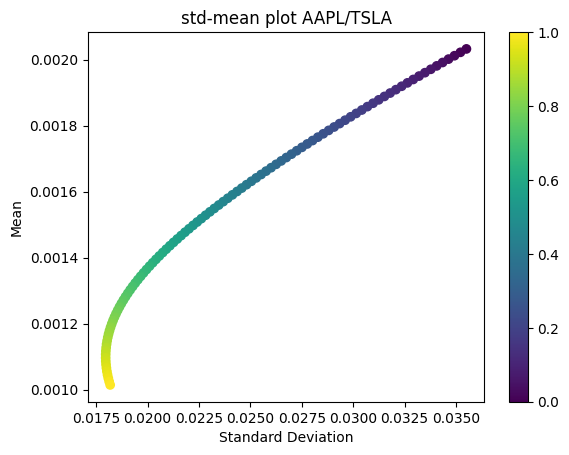

In [74]:
x = []
y = []
c = []
for k in np.linspace(0, 1, 100):
    merged_returns = k * stock_returns[name1].values + (1 - k) * stock_returns[name2].values
    x.append(merged_returns.std())
    y.append(merged_returns.mean())
    c.append(k)

plt.scatter(x, y, c=c, cmap='viridis')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean')
plt.title(f'std-mean plot {name1}/{name2}')
plt.colorbar()
plt.show()

## Dataset 생성

linespace로 균일하게 내분해서 절반, uniform으로 절반 생성한다

In [73]:
dataset = []
def add_dataset(alpha):
    # 첫번째 주식을 alpha, 두번째 주식을 1-alpha만큼.
    bins = np.linspace(-0.1, 0.1, num_bins + 1)
    returns = alpha * stock_returns[name1].values + (1 - alpha) * stock_returns[name2].values
    hist, _ = np.histogram(returns, bins=bins)
    dataset.append(hist/sum(hist))

for t in np.linspace(0, 1, num_dataset//2): # 절반은 직접 내분
    add_dataset(t)
for t in np.random.uniform(0, 1, num_dataset//2): # 절반은 랜덤
    add_dataset(t)

dataset = np.array(dataset)
print(dataset.shape)

(2000, 32)


In [217]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [218]:
noise_qubits = 5
code_qubits = 1
output_qubits = 5 # 실제로 출력 상태를 만드는데 쓰이는 개수
n_qubits = noise_qubits + code_qubits

n_layers = 30
BATCH_SIZE = 16

print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))
dev = qml.device("default.qubit", wires=n_qubits) # 제너레이터 돌려서 값 뽑아내는데 쓰임. 이중 몇개 골라서 판별자도 학습함.

n_qubits = 6 n_layers = 30


In [219]:
coeff = 0.1

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    generator_init(generator_input)
    for param in params:
        generator_layer(param)
    return qml.probs(wires=range(output_qubits))


def generator_forward(params, generator_input):
    generator_output = [generator_circuit(params, single_in) for single_in in generator_input] # (BATCH_SIZE, 2**output_qubits) 차원
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, 2**output_qubits) 차원
    return generator_output


def generator_train_step(params, generator_input, use_mine = False, _qmine = False):
    code_input = generator_input[:, -code_qubits:]

    generator_output = generator_forward(params, generator_input)
    generator_output = generator_output.to(torch.float32) # (BATCH_SIZE, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = torch.log(1-disc_output).mean()
    

    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi


    return generator_output, gan_loss

In [221]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=num_bins):
        super().__init__()
        self.hidden_size = 100
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 100
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(2**output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2


disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss

In [222]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
print("parameter shape: ", generator_params.shape)
discriminator = LinearDiscriminator()
mine = LinearMine()

G_lr = 1e-3
D_lr = 2e-5
M_lr = 1e-3
use_mine = True
use_qmine = False
G_opt = torch.optim.Adam([generator_params], lr=G_lr)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

G_scheduler = torch.optim.lr_scheduler.StepLR(G_opt, step_size=30, gamma=0.7)
D_scheduler = torch.optim.lr_scheduler.StepLR(D_opt, step_size=30, gamma=0.85)
M_scheduler = torch.optim.lr_scheduler.StepLR(M_opt, step_size=30, gamma=0.7)

parameter shape:  torch.Size([30, 6, 3])


In [223]:
import os
############# 가장 최신 버전 폴더로 저장한다 #############
file_num = 1
title = f'mine={use_mine}_try={file_num}'
if not os.path.exists(f'result/{title}'):
    os.makedirs(f'result/{title}')
else:
    while os.path.exists(f'result/{title}'):
        file_num += 1
        title = f'mine={use_mine}_try={file_num}'
        if not os.path.exists(f'result/{title}'):
            os.makedirs(f'result/{title}')
            break
###################################################

with open(f'result/{title}/param.txt', 'w') as f:
    f.write('G_lr = {}\n'.format(G_lr))
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    f.write('G_scheduler: step={}, gamma={}\n'.format(G_scheduler.step_size, G_scheduler.gamma))
    f.write('D_scheduler: step={}, gamma={}\n'.format(D_scheduler.step_size, D_scheduler.gamma))
    f.write('M_scheduler: step={}, gamma={}\n'.format(M_scheduler.step_size, M_scheduler.gamma))
    f.write('coeff = {}\n'.format(coeff))
    f.write('use_mine = {}\n'.format(use_mine))
    f.write('use_qmine = {}\n'.format(use_qmine))
    f.write('n_qubits = {}\n'.format(n_qubits))
    f.write('noise_qubits = {}\n'.format(noise_qubits))
    f.write('code_qubits = {}\n'.format(code_qubits))
    f.write('n_layers = {}\n'.format(n_layers))
    f.write('param shape = {}\n'.format(generator_params.shape))

In [225]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

def visualize_output(gen_outputs, gen_codes, title, rep, recorder):
    warnings.simplefilter("ignore")


    random_indices = np.random.choice(gen_outputs.shape[0], size=9, replace=False)
    selected_samples = [gen_outputs[i] for i in random_indices]
    selected_codes = [gen_codes[i][0] for i in random_indices]

    sorted_indices = np.argsort(selected_codes)
    sorted_selected_codes = [selected_codes[i] for i in sorted_indices]
    sorted_selected_samples = [selected_samples[i] for i in sorted_indices]

    plt.figure(figsize=(12, 8))

    for i, sample in enumerate(sorted_selected_samples):
        plt.subplot(3, 3, i + 1)
        plt.bar(np.linspace(-0.1, 0.1, num_bins), sample, width=0.2*(num_bins+1)/num_bins**2)
        plt.title(f'{sorted_selected_codes[i]:.3f}')
        plt.ylim(0, 0.2)
        plt.xlabel('Return')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f"Epoch {rep}, random imgs")
    plt.savefig(f'result/{title}/samples_{rep}.png')
    if rep % 5 == 0:
        plt.show()
    
    
    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} recorder'.format(rep))
    for i in range(code_qubits):
        plt.plot(recorder['mi'], label='mi', marker='o')
        plt.plot(recorder['d_loss'], label='d_loss', marker='o')
        plt.plot(recorder['g_loss'], label='g_loss', marker='o')

    plt.xlabel('epoch')
    plt.ylabel('values')
    plt.ylim(-1, 1)
    plt.title(f'record (rep={rep})')
    plt.legend()
    plt.savefig(f'result/{title}/record_{rep}.png', dpi=100)
    if rep % 5 == 0:
        plt.show()
    plt.clf()


100%|██████████| 31/31 [01:22<00:00,  2.66s/it, G_loss=-.67, D_loss=0.693, MI=0.000879] 


epoch: 1, D_loss: 0.6933324817688234, G_loss: -0.6703657104123023, MI = 0.0008794136585727815


100%|██████████| 31/31 [01:22<00:00,  2.68s/it, G_loss=-.675, D_loss=0.693, MI=0.00417]


epoch: 2, D_loss: 0.6930553451661141, G_loss: -0.6745257204578768, MI = 0.00417460645398786


100%|██████████| 31/31 [01:26<00:00,  2.80s/it, G_loss=-.678, D_loss=0.693, MI=0.0139] 


epoch: 3, D_loss: 0.692682477735704, G_loss: -0.678291957224569, MI = 0.013915870458849015


100%|██████████| 31/31 [01:29<00:00,  2.90s/it, G_loss=-.683, D_loss=0.692, MI=0.0356]


epoch: 4, D_loss: 0.6921755421546197, G_loss: -0.6828587901207709, MI = 0.035551795075016636


100%|██████████| 31/31 [01:29<00:00,  2.87s/it, G_loss=-.689, D_loss=0.692, MI=0.0783]


epoch: 5, D_loss: 0.6915986672524483, G_loss: -0.6887291208390267, MI = 0.0783259061075026


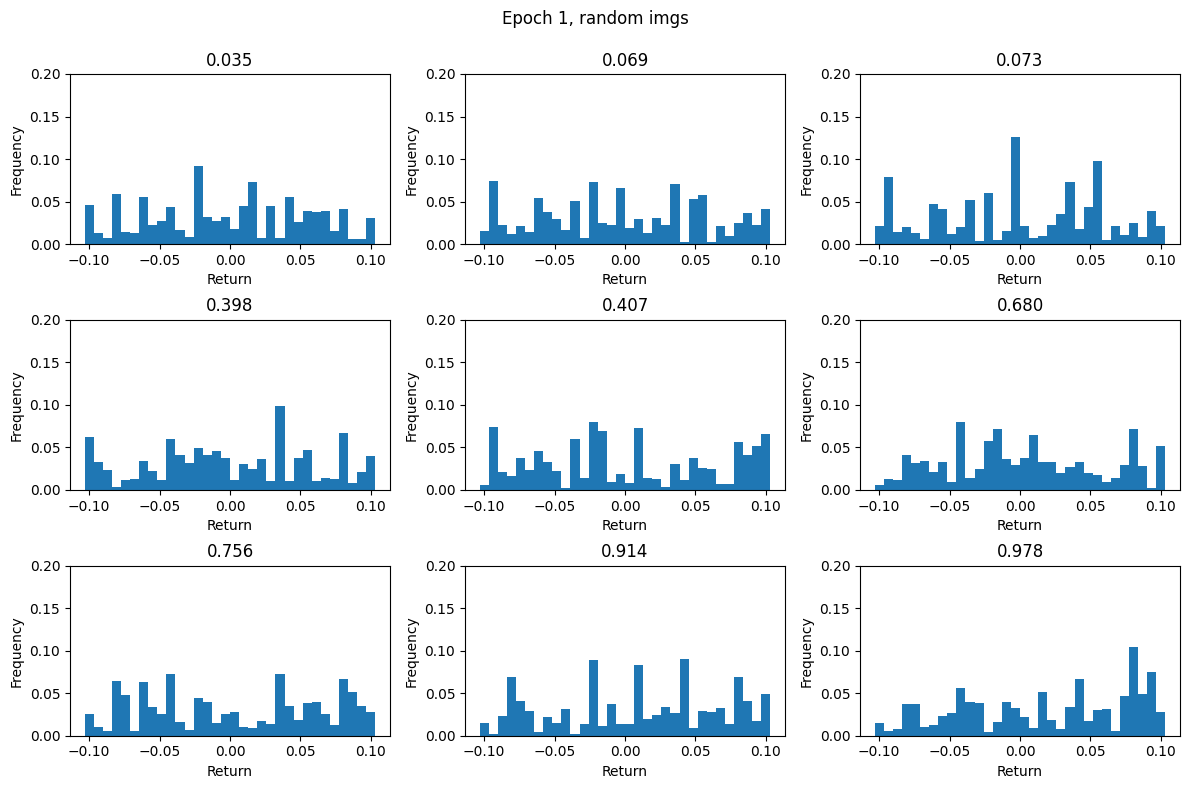

<Figure size 1000x400 with 0 Axes>

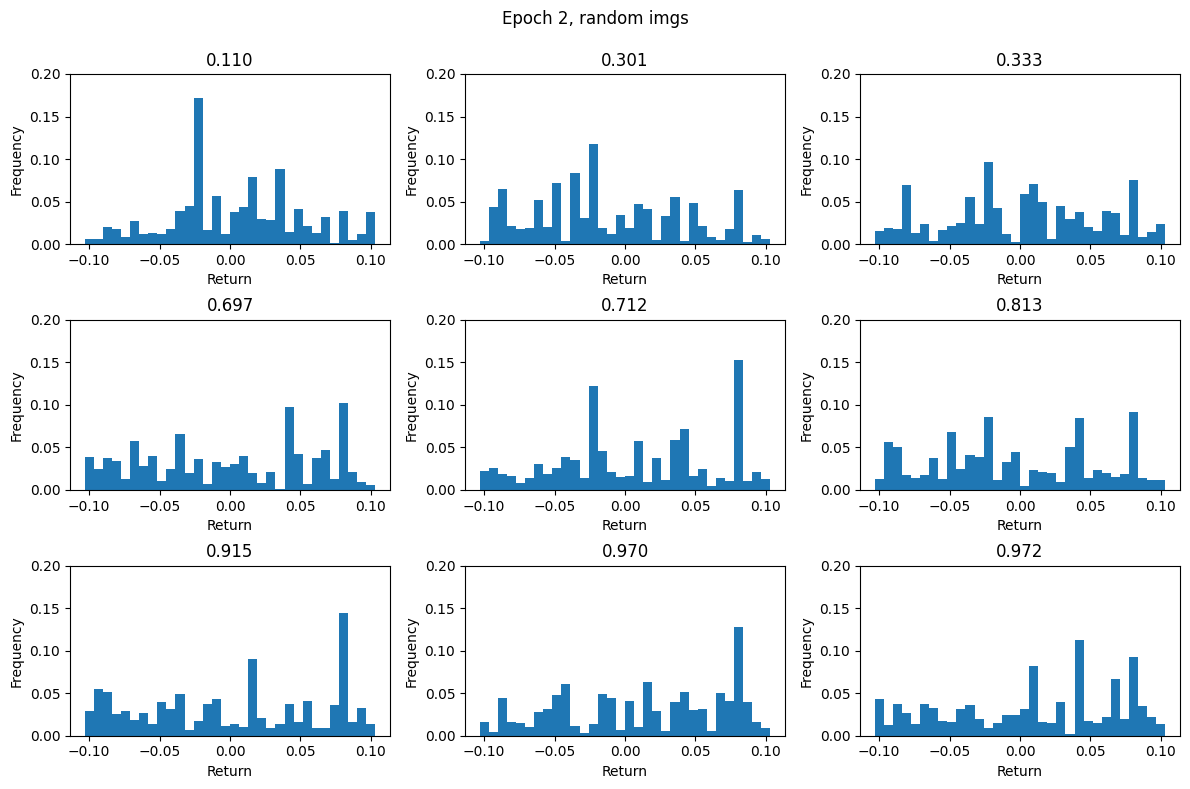

<Figure size 1000x400 with 0 Axes>

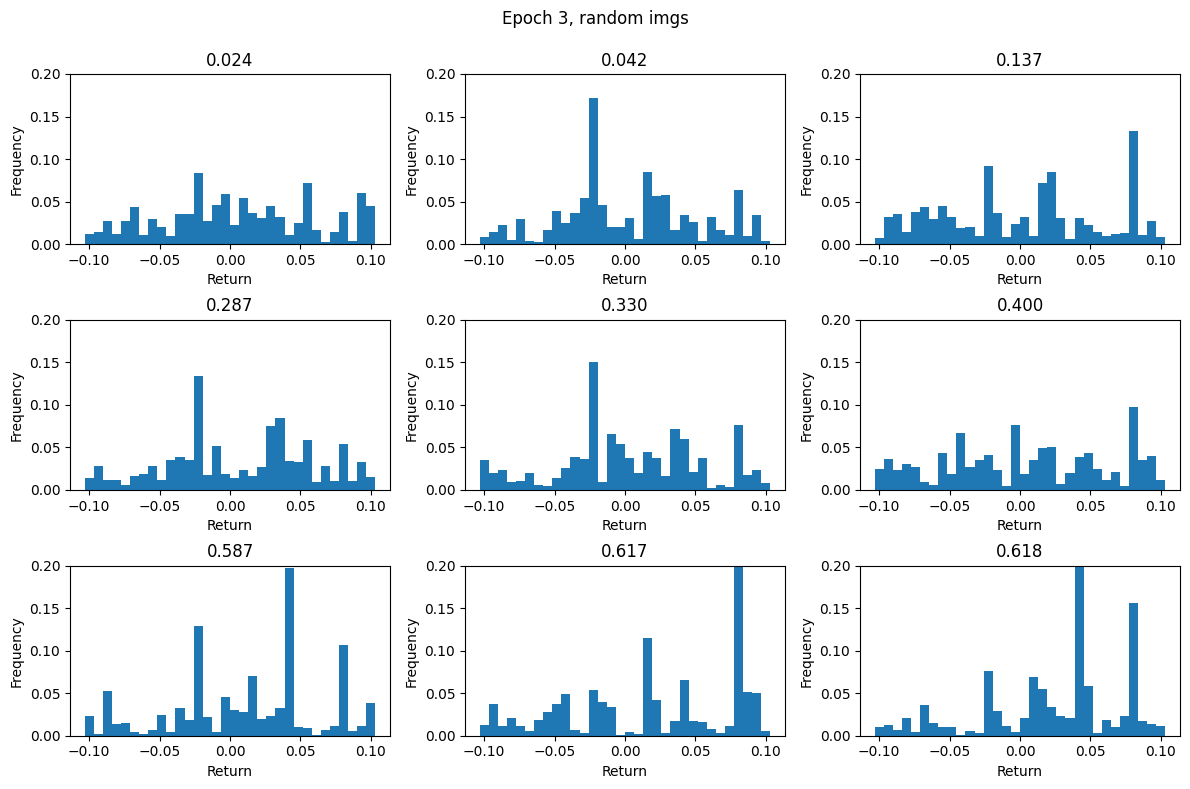

<Figure size 1000x400 with 0 Axes>

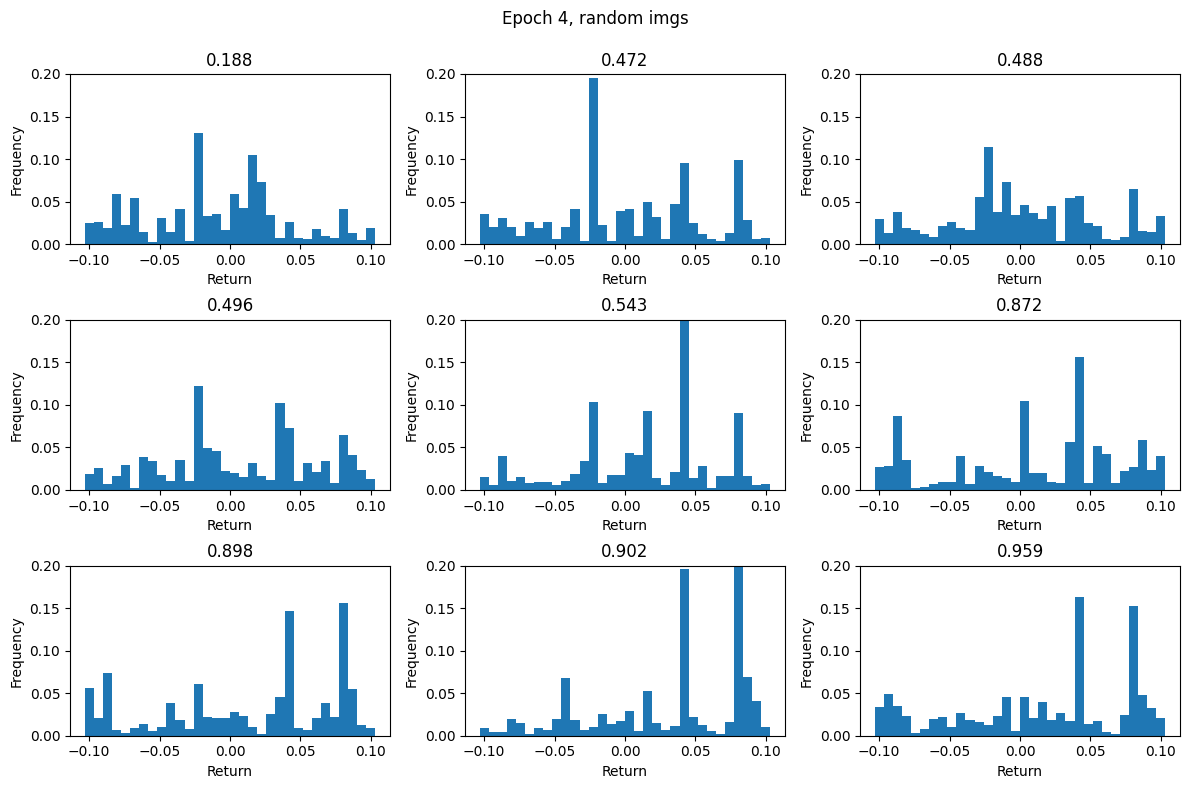

<Figure size 1000x400 with 0 Axes>

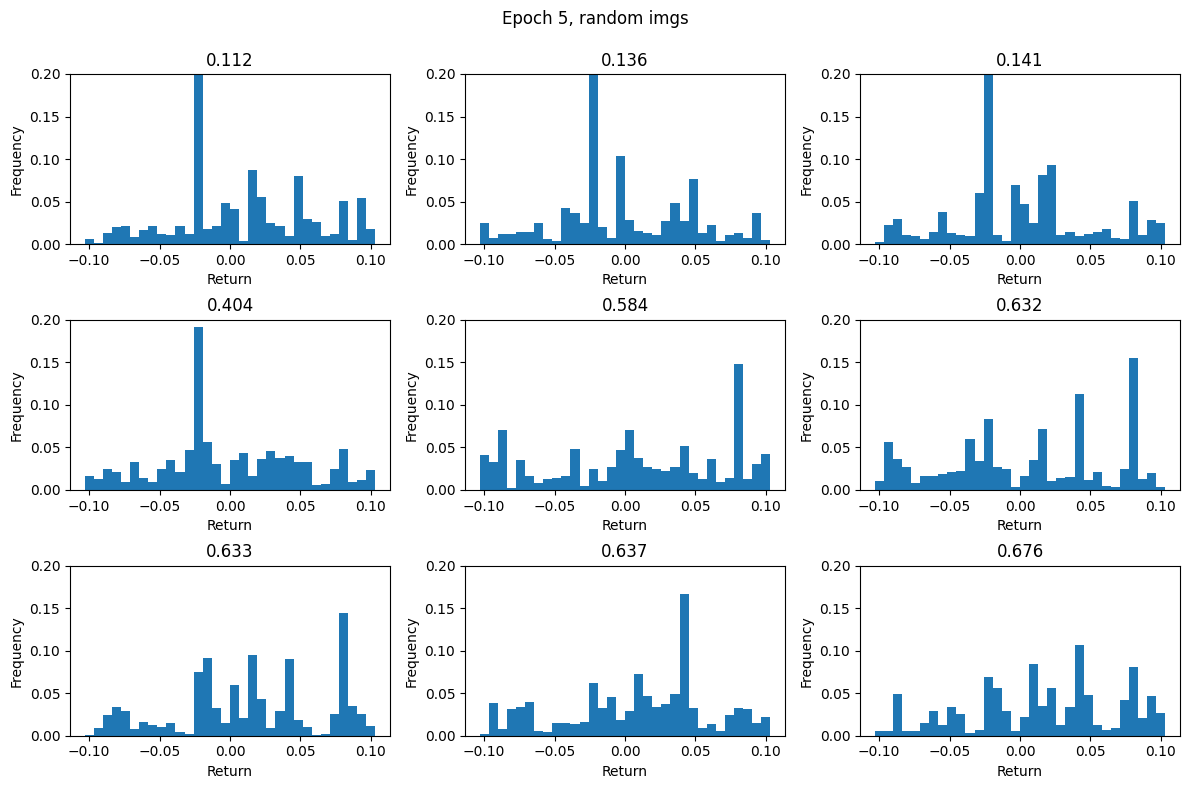

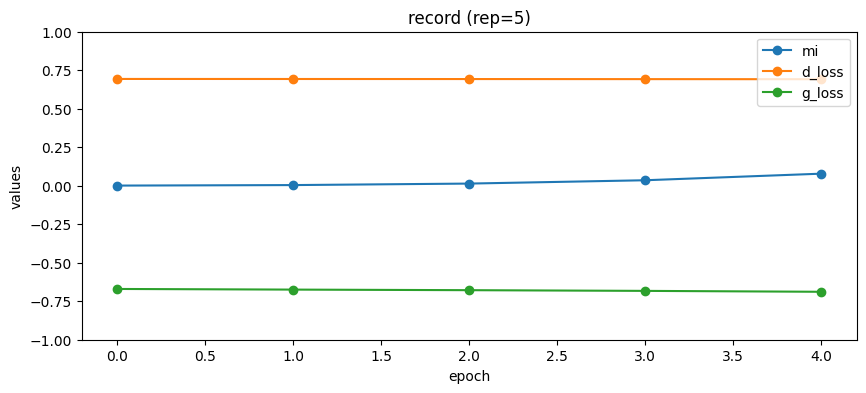

100%|██████████| 31/31 [01:24<00:00,  2.73s/it, G_loss=-.697, D_loss=0.691, MI=0.148]


epoch: 6, D_loss: 0.690826089151444, G_loss: -0.6966643314207753, MI = 0.1476136407544536


100%|██████████| 31/31 [01:22<00:00,  2.66s/it, G_loss=-.705, D_loss=0.69, MI=0.22] 


epoch: 7, D_loss: 0.6896857311648708, G_loss: -0.7049721364052065, MI = 0.22003654799153727


100%|██████████| 31/31 [01:24<00:00,  2.74s/it, G_loss=-.714, D_loss=0.688, MI=0.283]


epoch: 8, D_loss: 0.6883186717187205, G_loss: -0.7141516516285558, MI = 0.2827839101514509


100%|██████████| 31/31 [01:25<00:00,  2.75s/it, G_loss=-.72, D_loss=0.687, MI=0.348] 


epoch: 9, D_loss: 0.6865302728068444, G_loss: -0.7200225476295717, MI = 0.3478186178591944


100%|██████████| 31/31 [01:30<00:00,  2.91s/it, G_loss=-.725, D_loss=0.684, MI=0.398]


epoch: 10, D_loss: 0.6844454715328832, G_loss: -0.7254247088586131, MI = 0.3983193289849066


<Figure size 640x480 with 0 Axes>

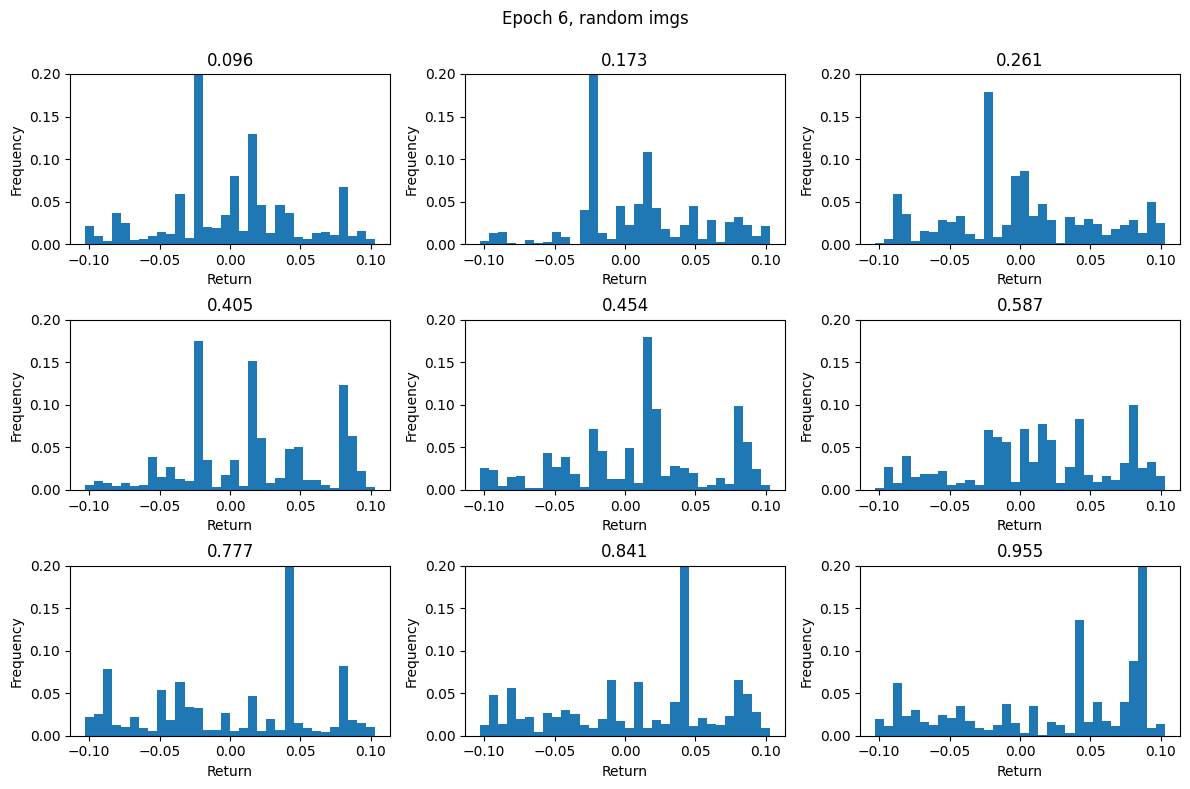

<Figure size 1000x400 with 0 Axes>

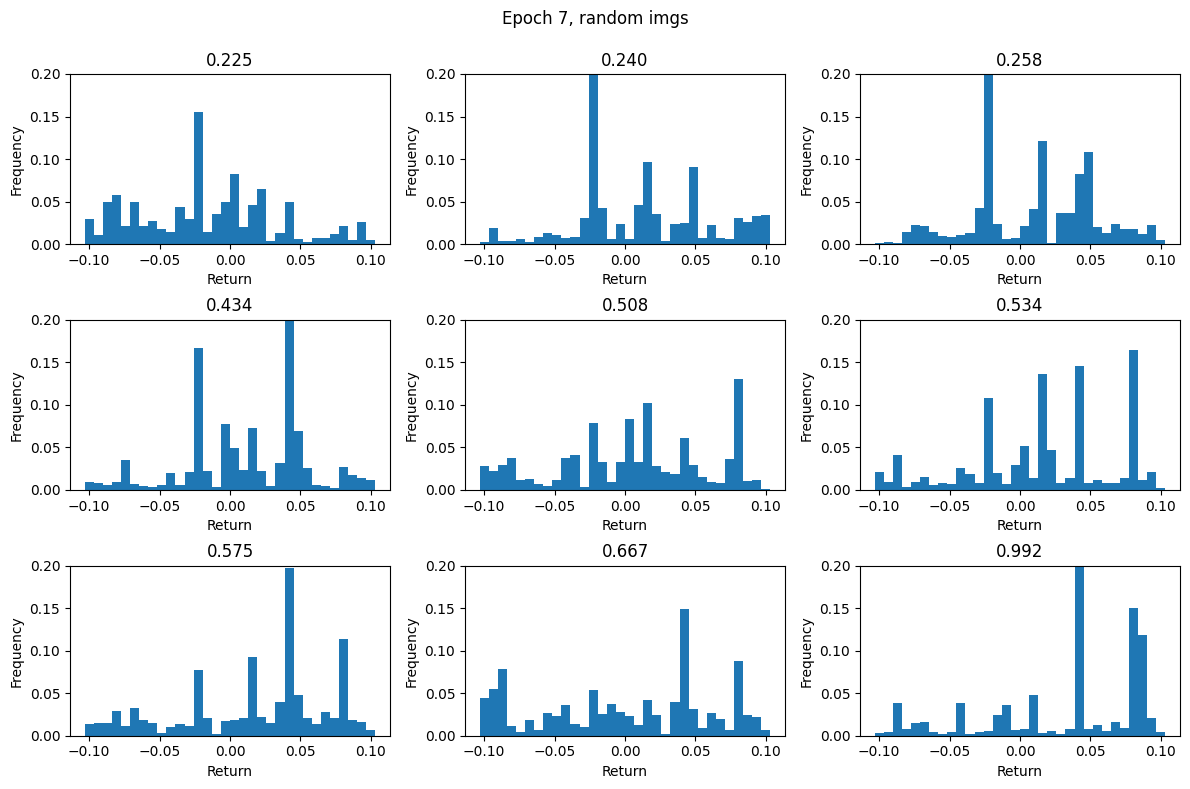

<Figure size 1000x400 with 0 Axes>

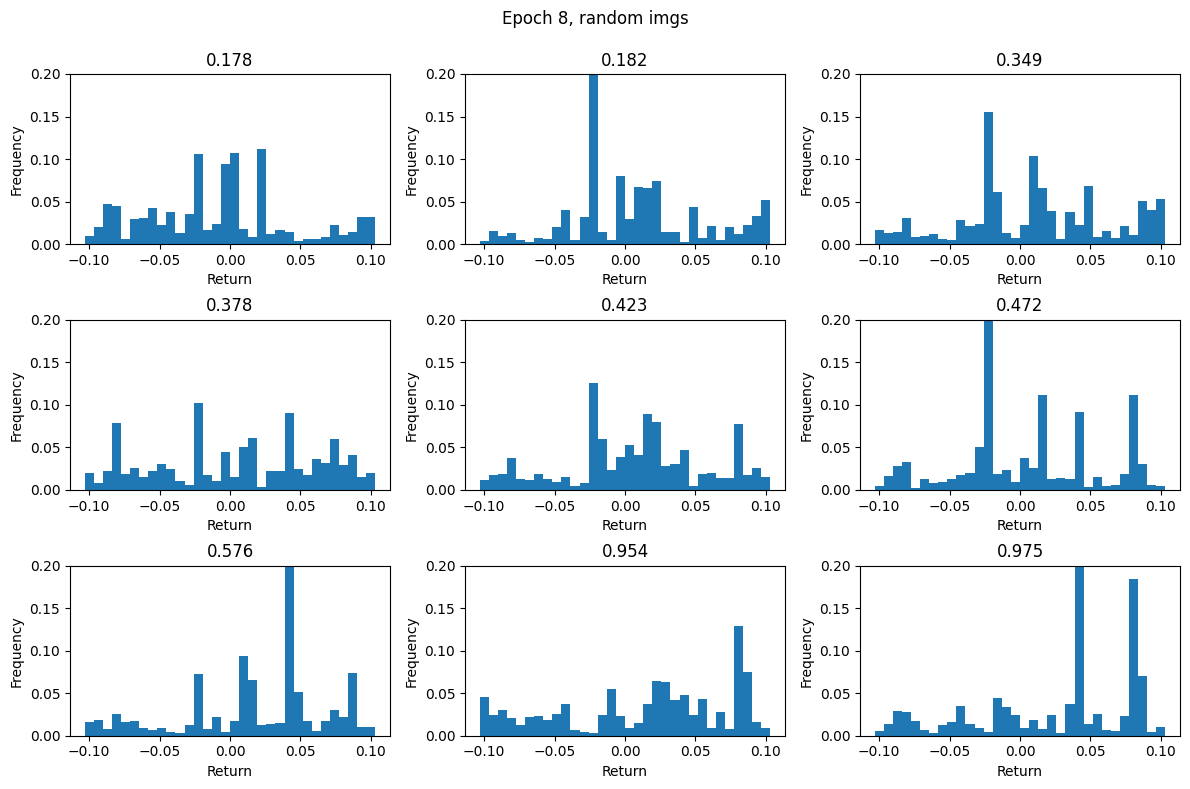

<Figure size 1000x400 with 0 Axes>

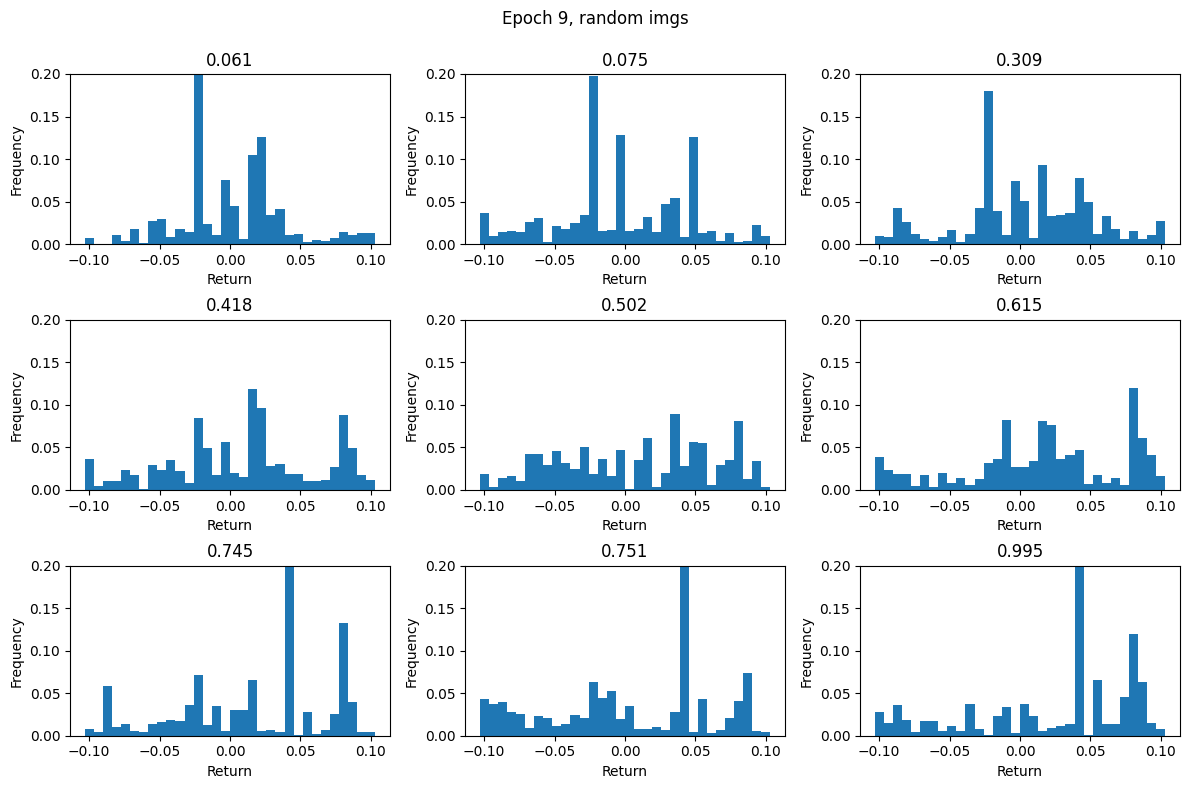

<Figure size 1000x400 with 0 Axes>

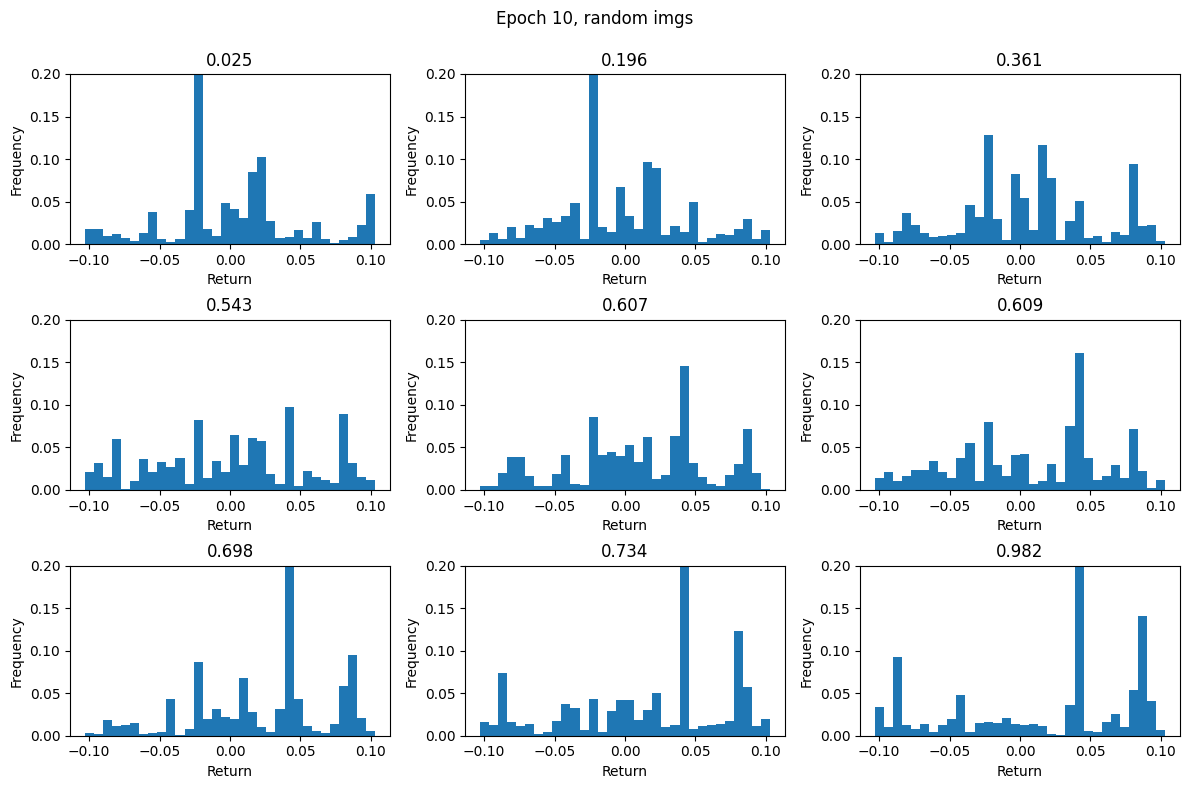

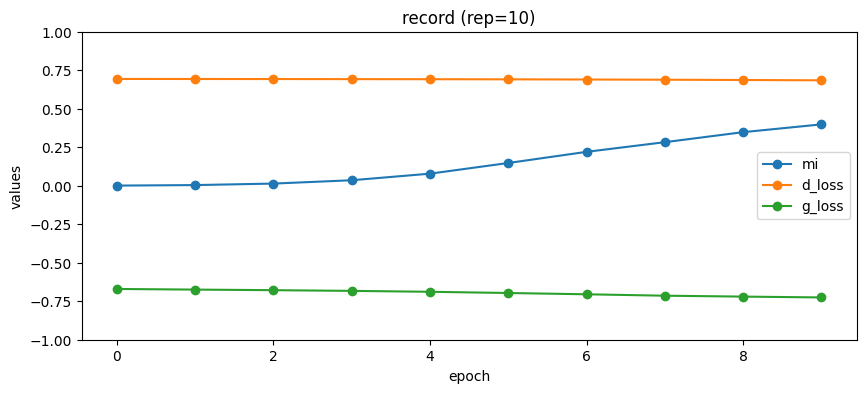

100%|██████████| 31/31 [01:28<00:00,  2.86s/it, G_loss=-.728, D_loss=0.682, MI=0.446]


epoch: 11, D_loss: 0.6818564034277393, G_loss: -0.7279469986115733, MI = 0.44551726695029964


100%|██████████| 31/31 [01:29<00:00,  2.87s/it, G_loss=-.738, D_loss=0.679, MI=0.527]


epoch: 12, D_loss: 0.678893554595209, G_loss: -0.7377432796262926, MI = 0.5267752620481676


100%|██████████| 31/31 [01:28<00:00,  2.85s/it, G_loss=-.733, D_loss=0.676, MI=0.557]


epoch: 13, D_loss: 0.676301404353111, G_loss: -0.7334829703454049, MI = 0.5568098983457012


100%|██████████| 31/31 [01:24<00:00,  2.72s/it, G_loss=-.74, D_loss=0.674, MI=0.619] 


epoch: 14, D_loss: 0.6735660760633407, G_loss: -0.7404432162161796, MI = 0.6188775031797348


100%|██████████| 31/31 [01:25<00:00,  2.76s/it, G_loss=-.736, D_loss=0.67, MI=0.568] 


epoch: 15, D_loss: 0.6699667553747853, G_loss: -0.7357242280437101, MI = 0.5683546969967503


<Figure size 640x480 with 0 Axes>

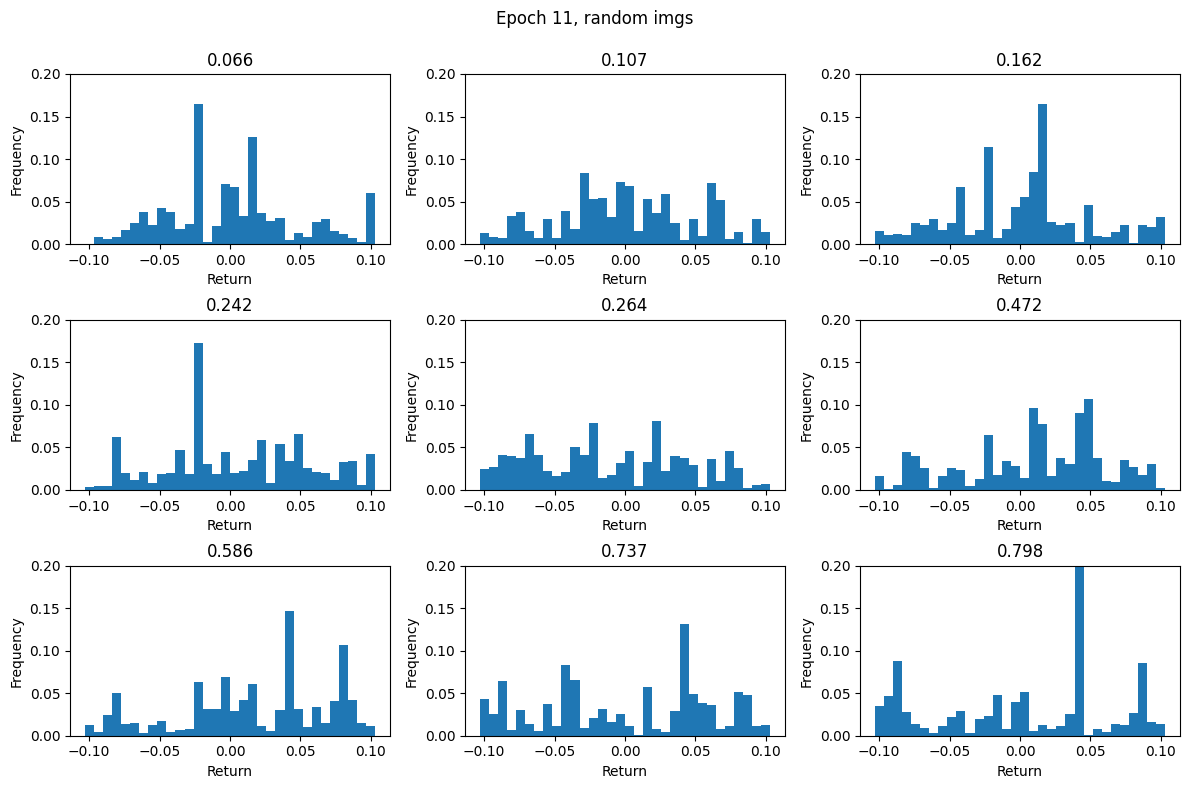

<Figure size 1000x400 with 0 Axes>

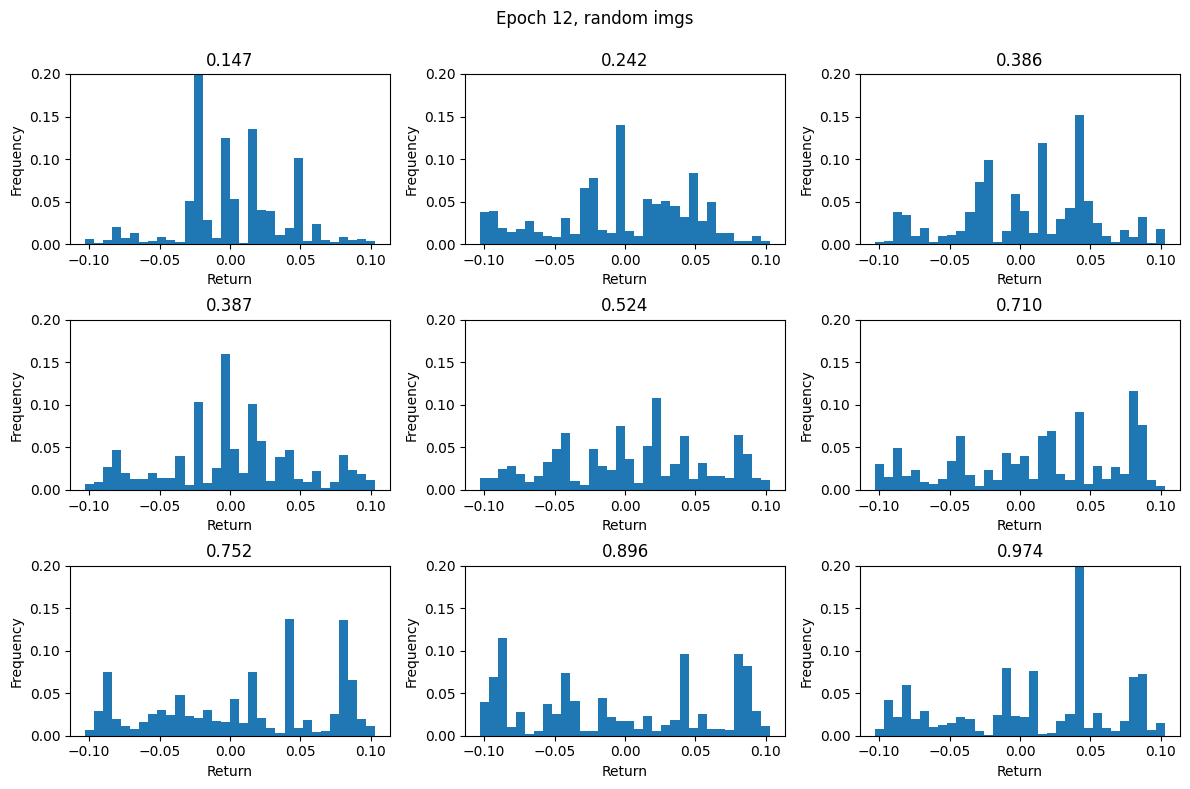

<Figure size 1000x400 with 0 Axes>

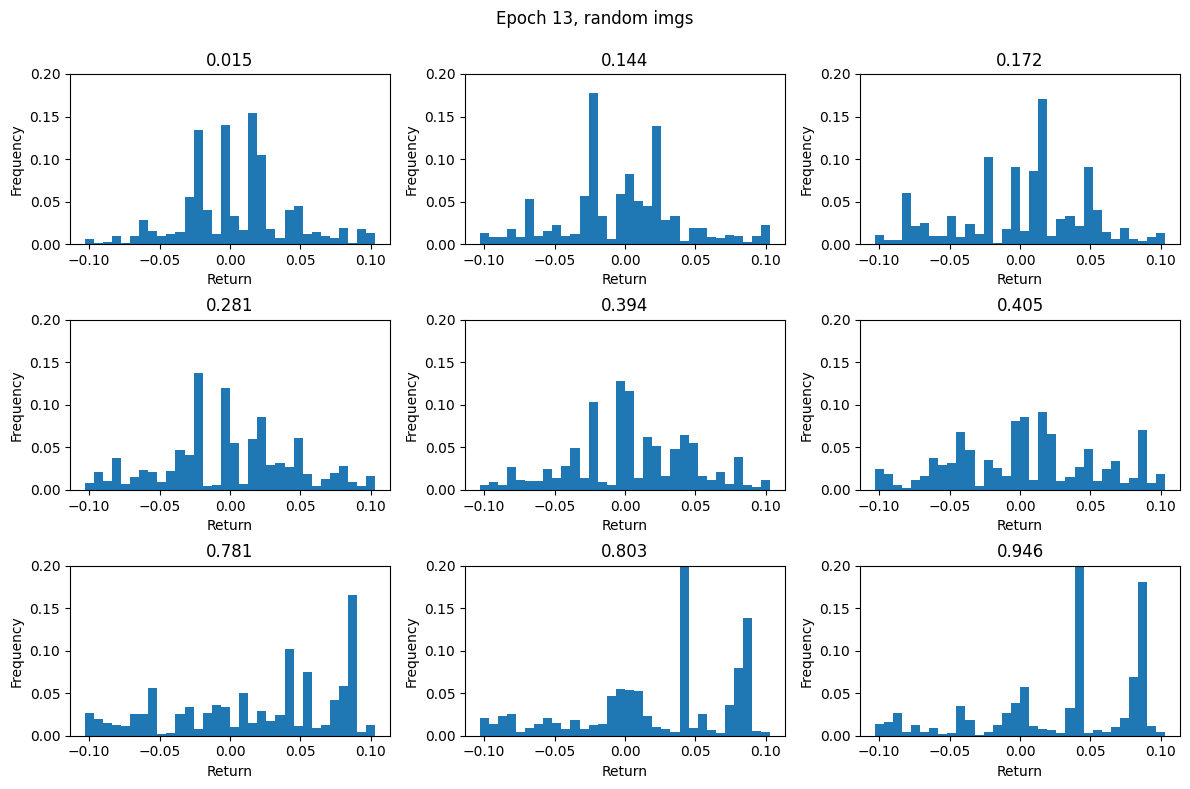

<Figure size 1000x400 with 0 Axes>

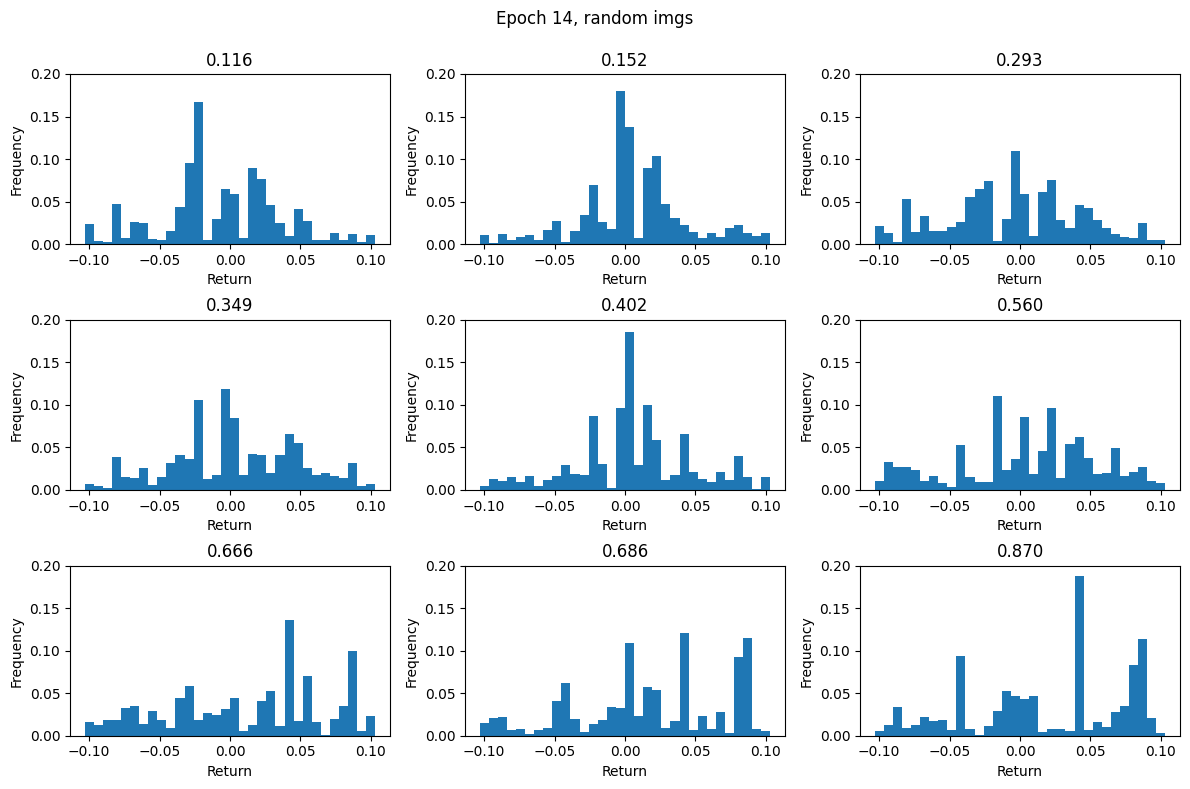

<Figure size 1000x400 with 0 Axes>

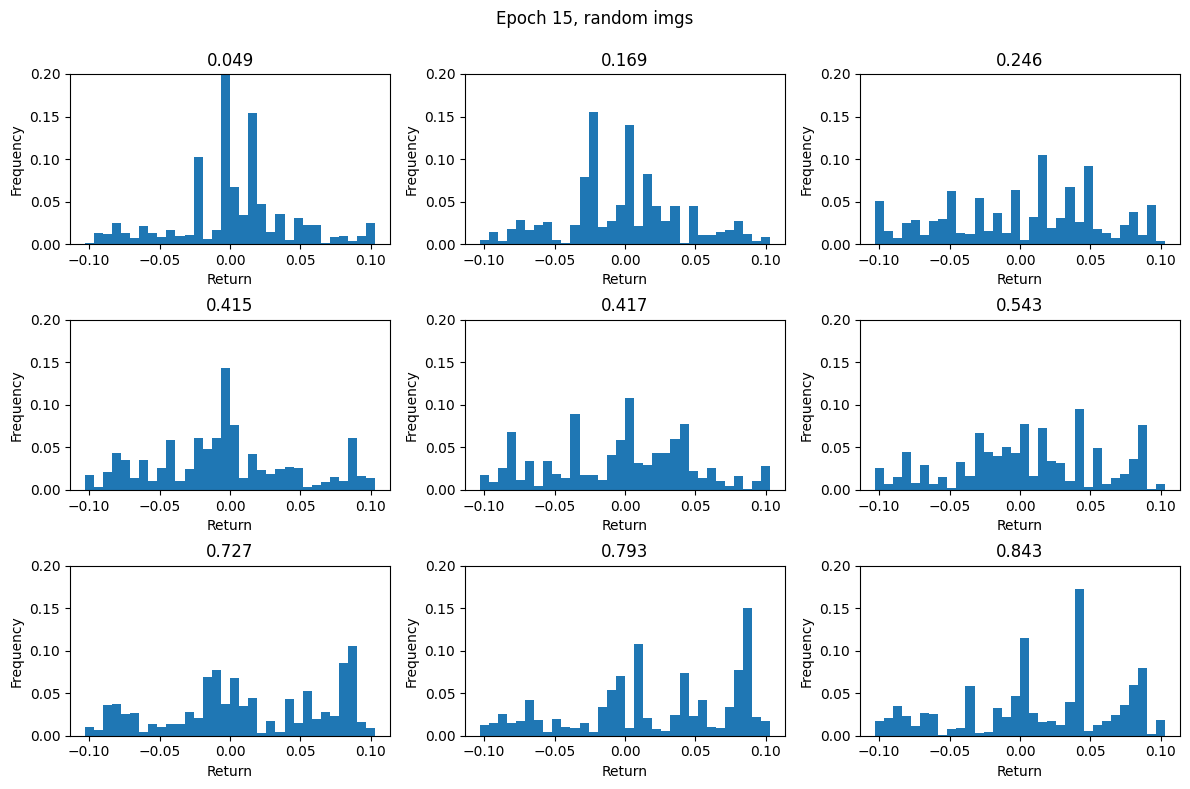

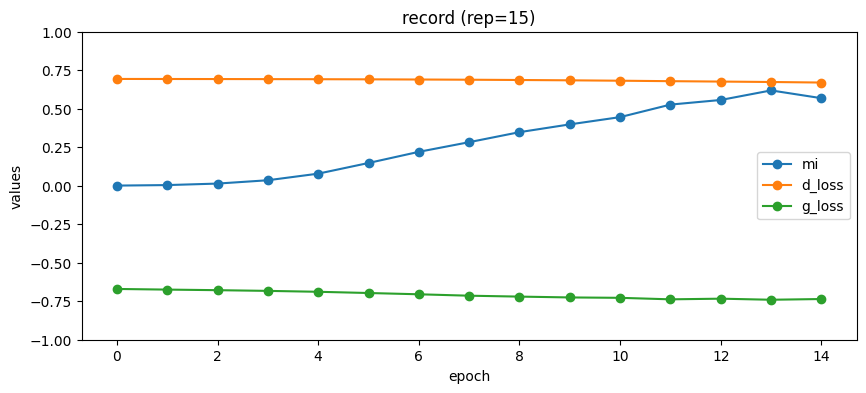

100%|██████████| 31/31 [01:19<00:00,  2.57s/it, G_loss=-.734, D_loss=0.667, MI=0.644]


epoch: 16, D_loss: 0.6672199887614096, G_loss: -0.7337406508384212, MI = 0.6436933625128961


100%|██████████| 31/31 [01:19<00:00,  2.56s/it, G_loss=-.732, D_loss=0.664, MI=0.591]


epoch: 17, D_loss: 0.6639264552823959, G_loss: -0.7324174219562162, MI = 0.5907672922457418


100%|██████████| 31/31 [01:21<00:00,  2.62s/it, G_loss=-.722, D_loss=0.662, MI=0.661]


epoch: 18, D_loss: 0.6616868934323711, G_loss: -0.7216356627402767, MI = 0.6611469522599251


100%|██████████| 31/31 [01:21<00:00,  2.63s/it, G_loss=-.718, D_loss=0.656, MI=0.671]


epoch: 19, D_loss: 0.6560431930326647, G_loss: -0.7184435571393659, MI = 0.6709699448077909


100%|██████████| 31/31 [01:20<00:00,  2.59s/it, G_loss=-.718, D_loss=0.65, MI=0.603] 


epoch: 20, D_loss: 0.6500667871967438, G_loss: -0.718375890485702, MI = 0.6033078758947311


<Figure size 640x480 with 0 Axes>

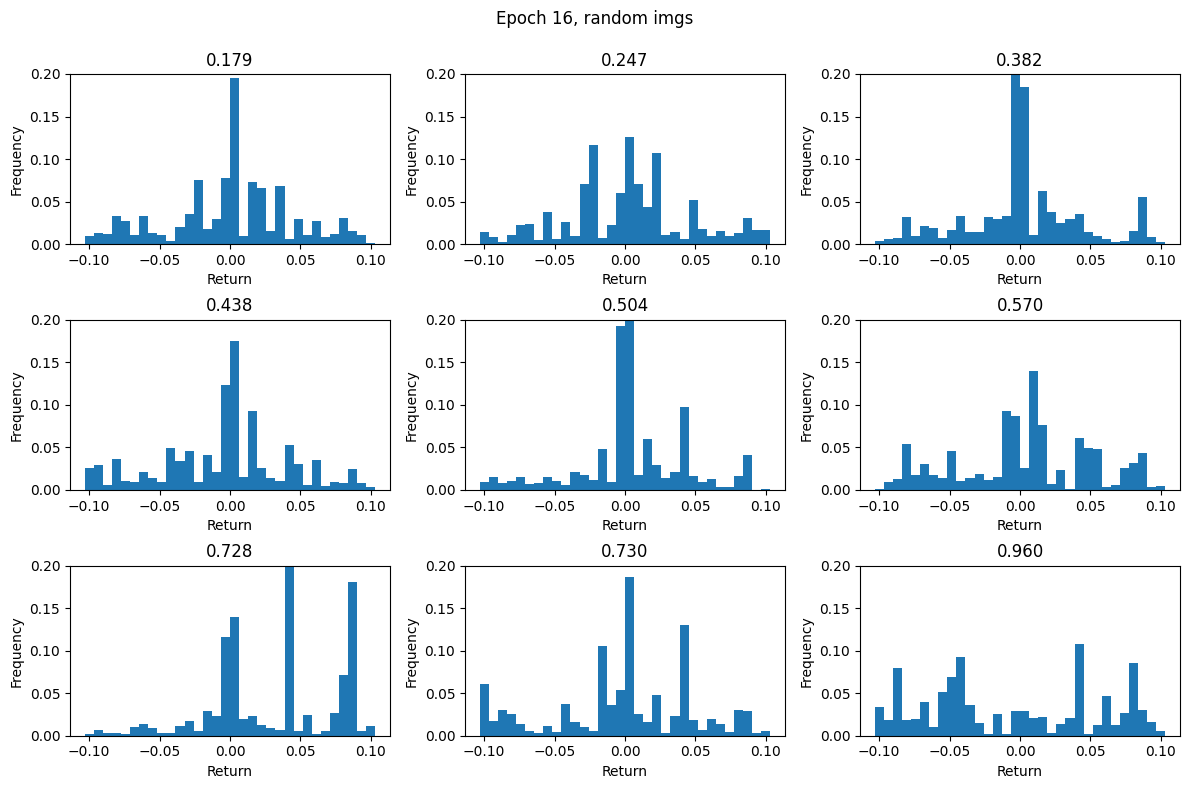

<Figure size 1000x400 with 0 Axes>

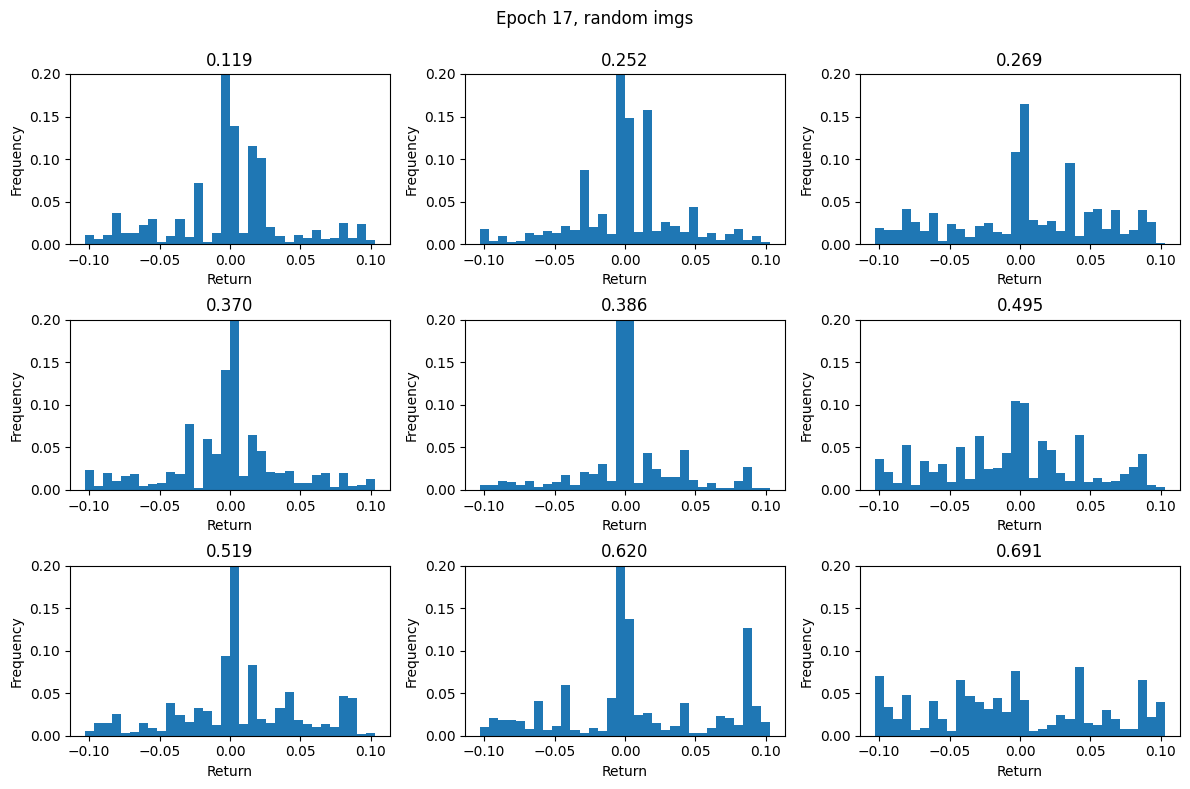

<Figure size 1000x400 with 0 Axes>

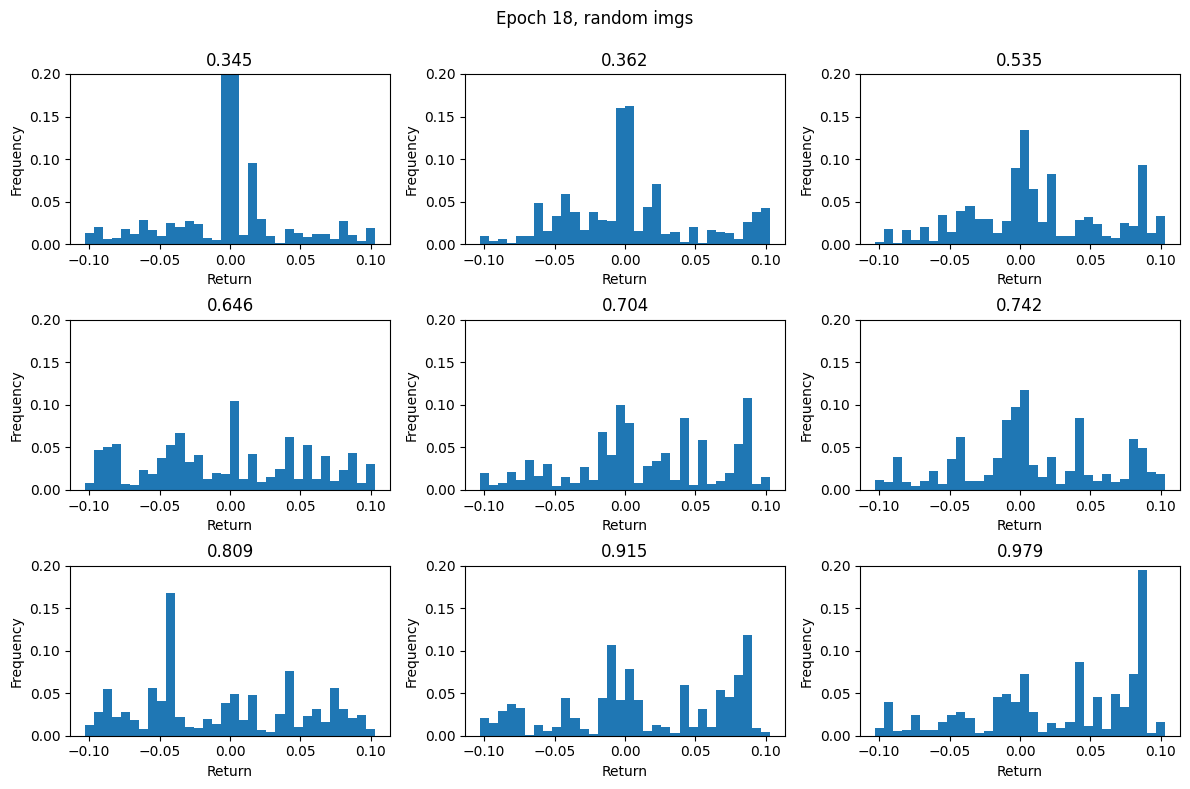

<Figure size 1000x400 with 0 Axes>

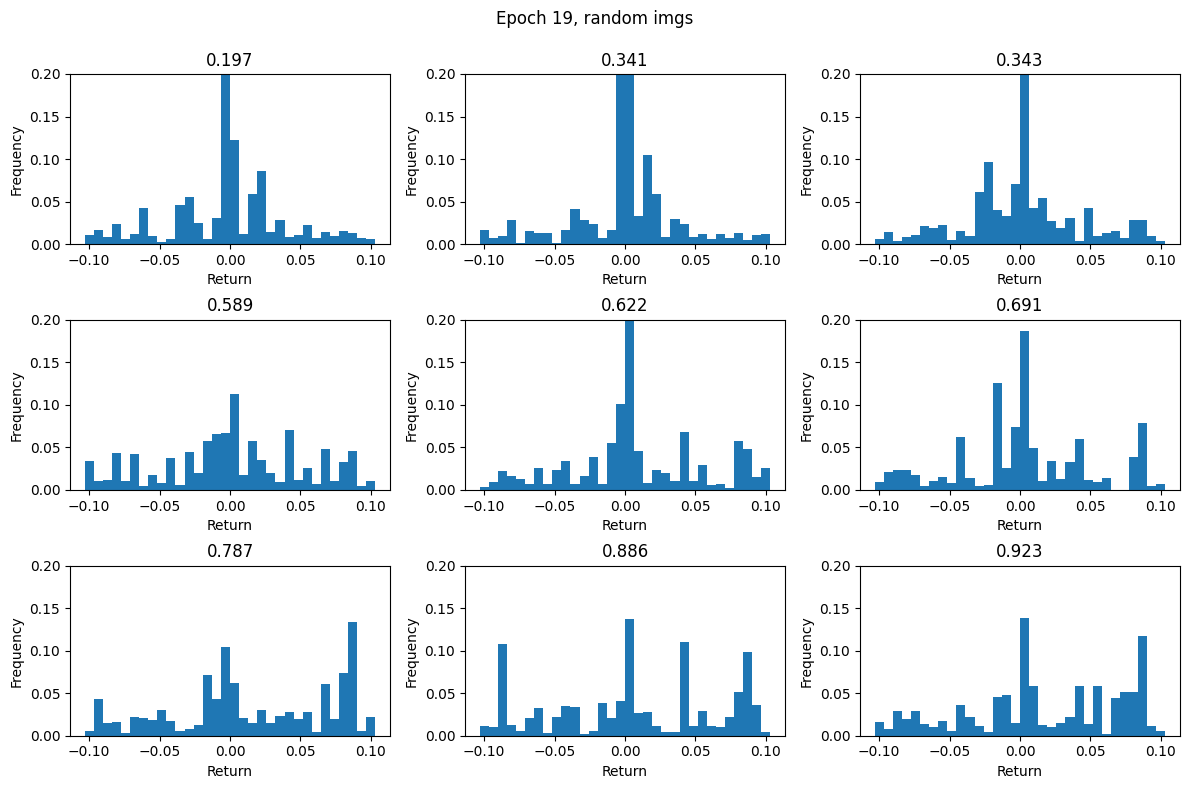

<Figure size 1000x400 with 0 Axes>

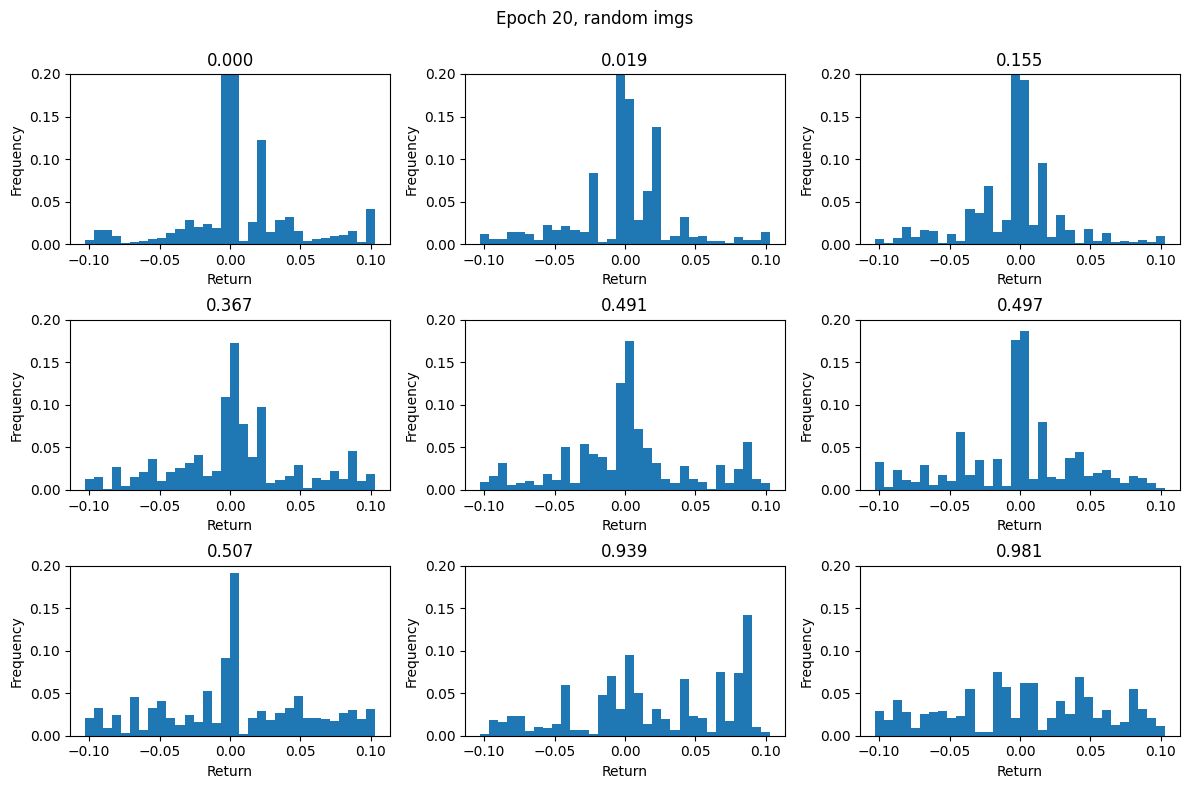

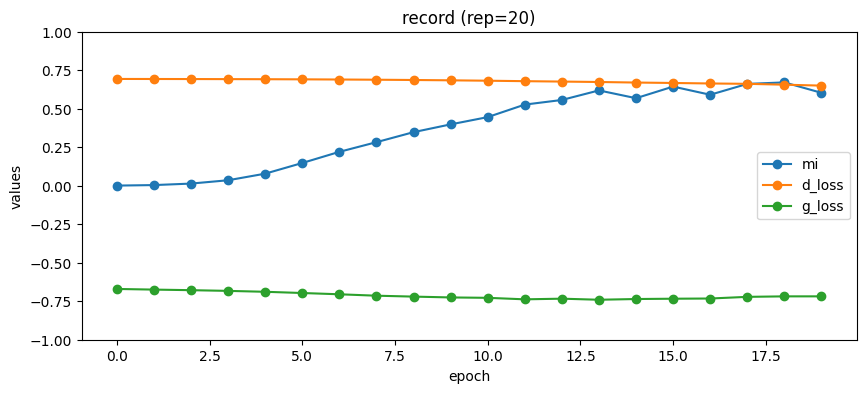

100%|██████████| 31/31 [01:18<00:00,  2.53s/it, G_loss=-.72, D_loss=0.645, MI=0.768] 


epoch: 21, D_loss: 0.6445910430723621, G_loss: -0.7203195325789913, MI = 0.7676087377532836


100%|██████████| 31/31 [01:20<00:00,  2.61s/it, G_loss=-.709, D_loss=0.637, MI=0.695]


epoch: 22, D_loss: 0.6368748776374324, G_loss: -0.7090163942306272, MI = 0.6954732316155587


100%|██████████| 31/31 [01:19<00:00,  2.55s/it, G_loss=-.701, D_loss=0.63, MI=0.664] 


epoch: 23, D_loss: 0.6304835734828826, G_loss: -0.7014257754048994, MI = 0.6639820039272308


100%|██████████| 31/31 [01:17<00:00,  2.50s/it, G_loss=-.694, D_loss=0.625, MI=0.706]


epoch: 24, D_loss: 0.6250669321706218, G_loss: -0.6937311541649603, MI = 0.7063283006991109


100%|██████████| 31/31 [01:17<00:00,  2.50s/it, G_loss=-.685, D_loss=0.615, MI=0.68] 


epoch: 25, D_loss: 0.6148027123943451, G_loss: -0.6849634416641728, MI = 0.6798858036918025


<Figure size 640x480 with 0 Axes>

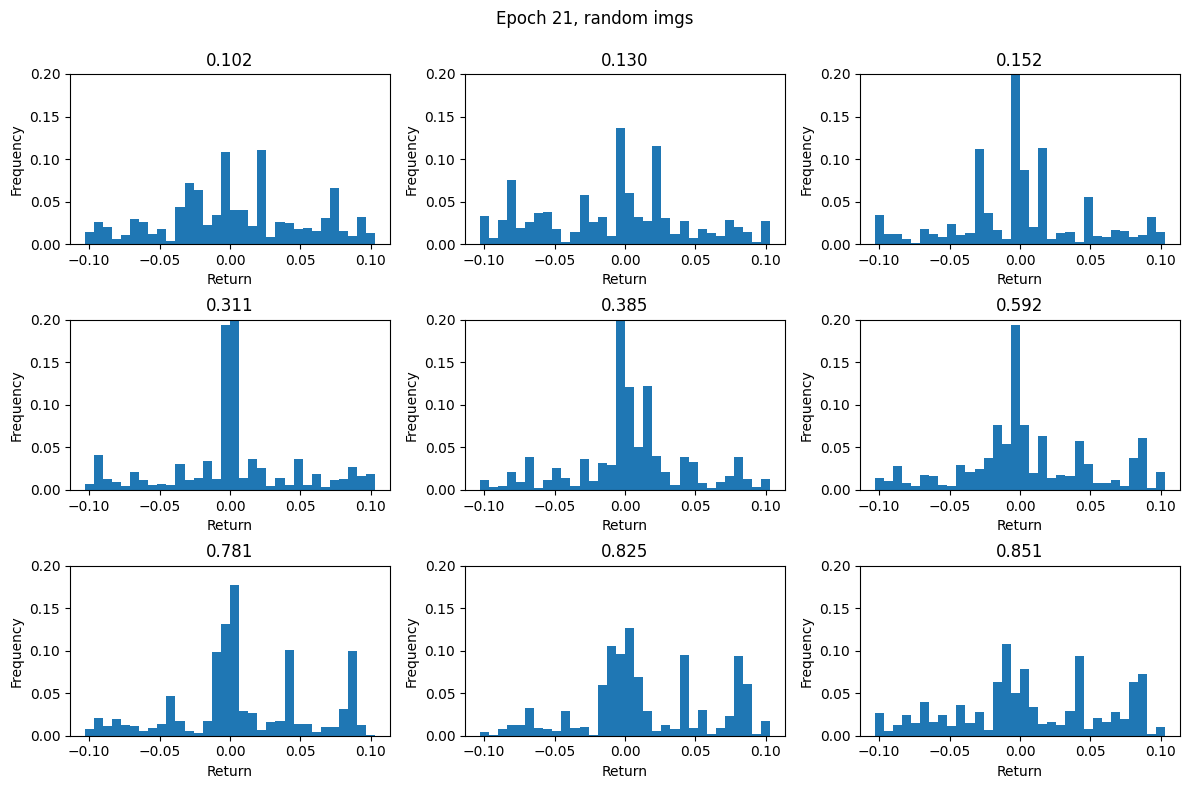

<Figure size 1000x400 with 0 Axes>

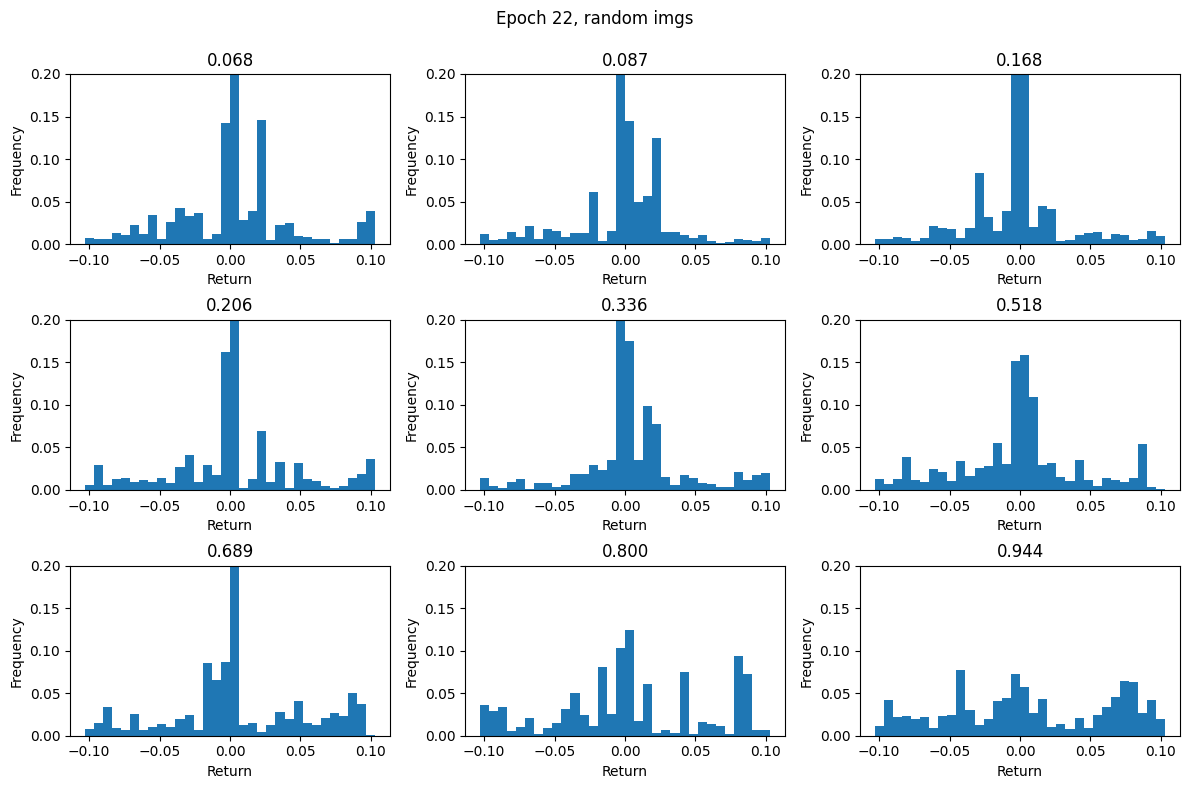

<Figure size 1000x400 with 0 Axes>

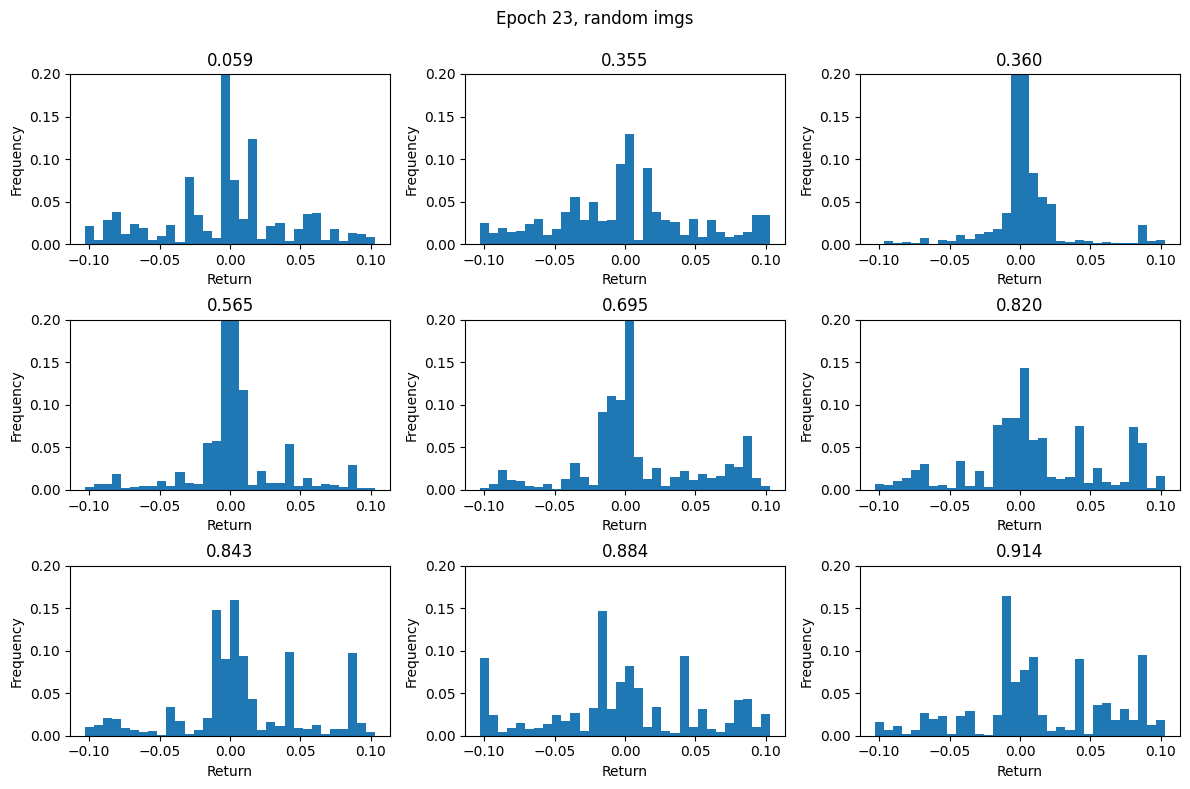

<Figure size 1000x400 with 0 Axes>

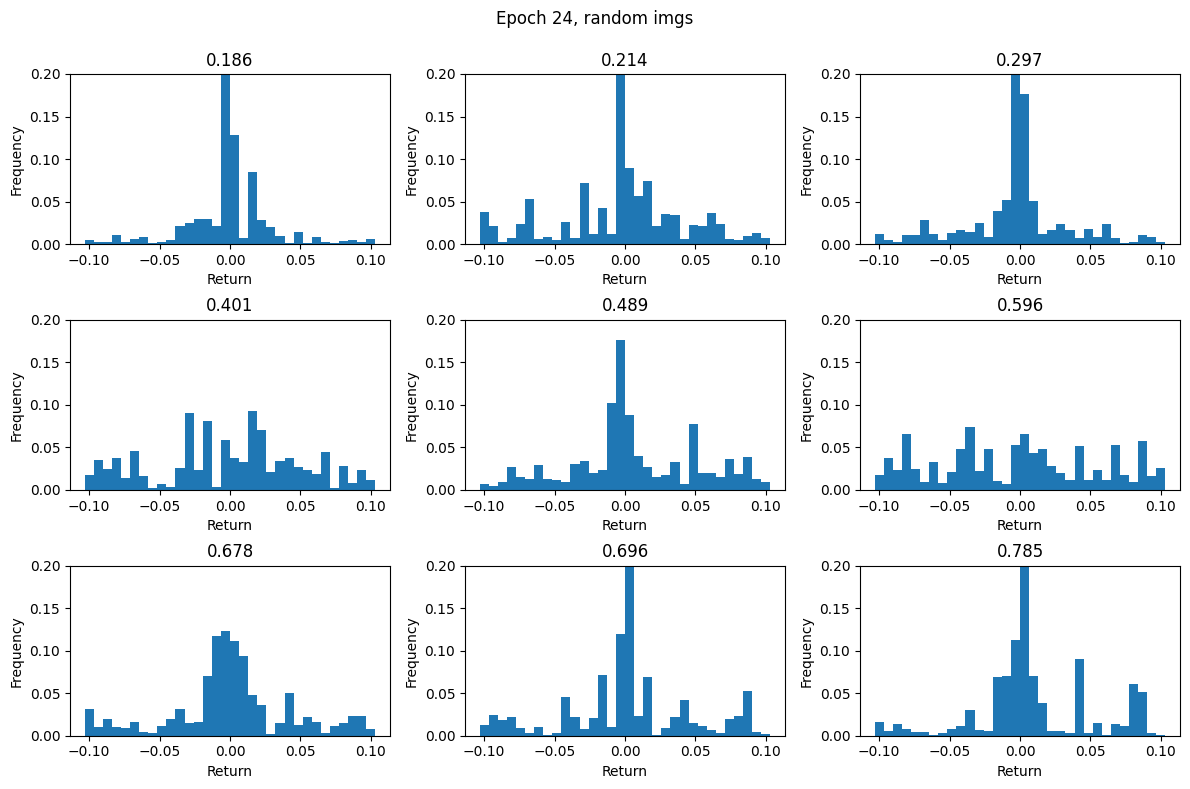

<Figure size 1000x400 with 0 Axes>

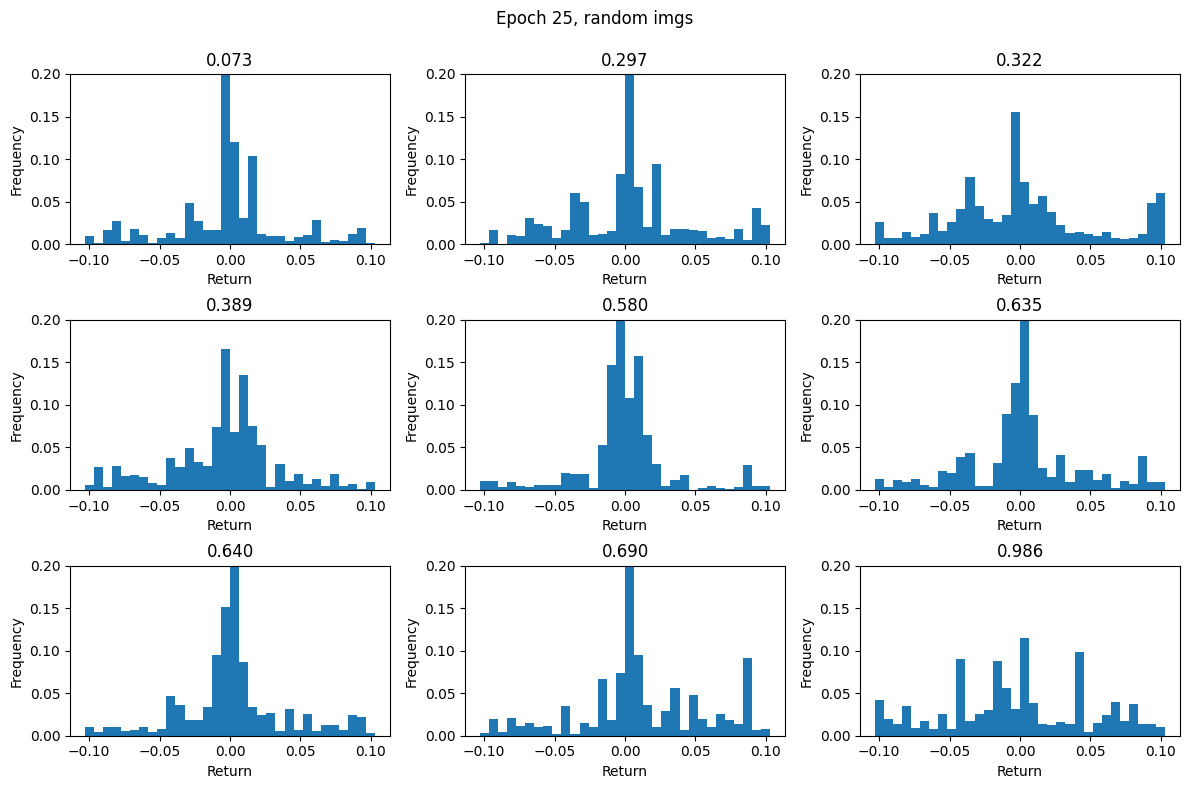

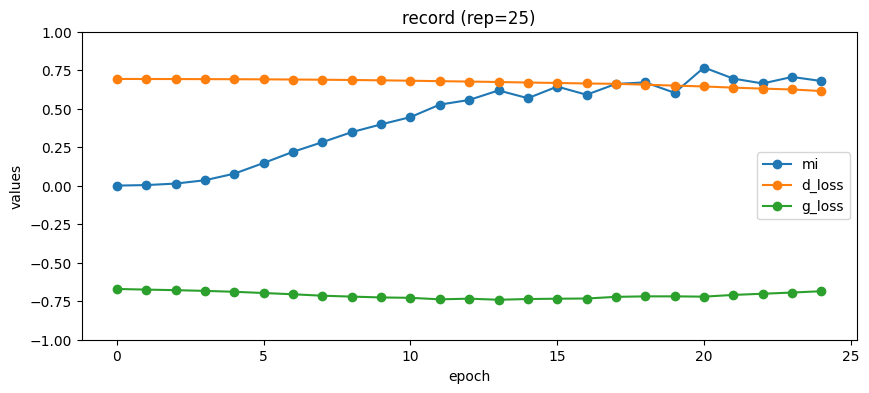

100%|██████████| 31/31 [01:17<00:00,  2.51s/it, G_loss=-.688, D_loss=0.608, MI=0.702]


epoch: 26, D_loss: 0.607549826945028, G_loss: -0.6878705774584124, MI = 0.7022755184481221


100%|██████████| 31/31 [01:19<00:00,  2.58s/it, G_loss=-.683, D_loss=0.594, MI=0.726]


epoch: 27, D_loss: 0.5943779349327087, G_loss: -0.6829183524654757, MI = 0.7259715382129915


100%|██████████| 31/31 [01:22<00:00,  2.65s/it, G_loss=-.666, D_loss=0.585, MI=0.697]


epoch: 28, D_loss: 0.5851892944305174, G_loss: -0.6660716302933232, MI = 0.6965734968262334


100%|██████████| 31/31 [01:22<00:00,  2.66s/it, G_loss=-.675, D_loss=0.574, MI=0.757]


epoch: 29, D_loss: 0.5741216751836962, G_loss: -0.6749143677373086, MI = 0.7574583984190418


100%|██████████| 31/31 [01:22<00:00,  2.66s/it, G_loss=-.67, D_loss=0.569, MI=0.732] 


epoch: 30, D_loss: 0.5689028828374801, G_loss: -0.670440423873163, MI = 0.7321259014068111


<Figure size 640x480 with 0 Axes>

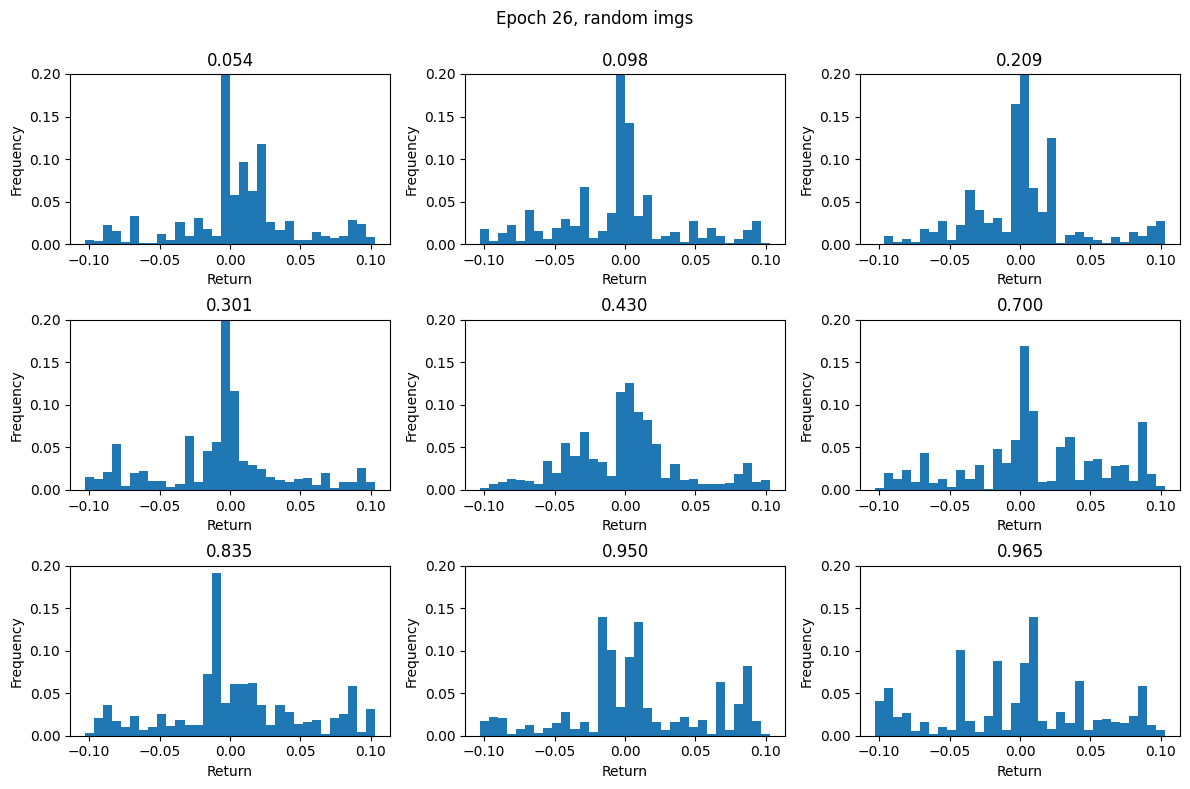

<Figure size 1000x400 with 0 Axes>

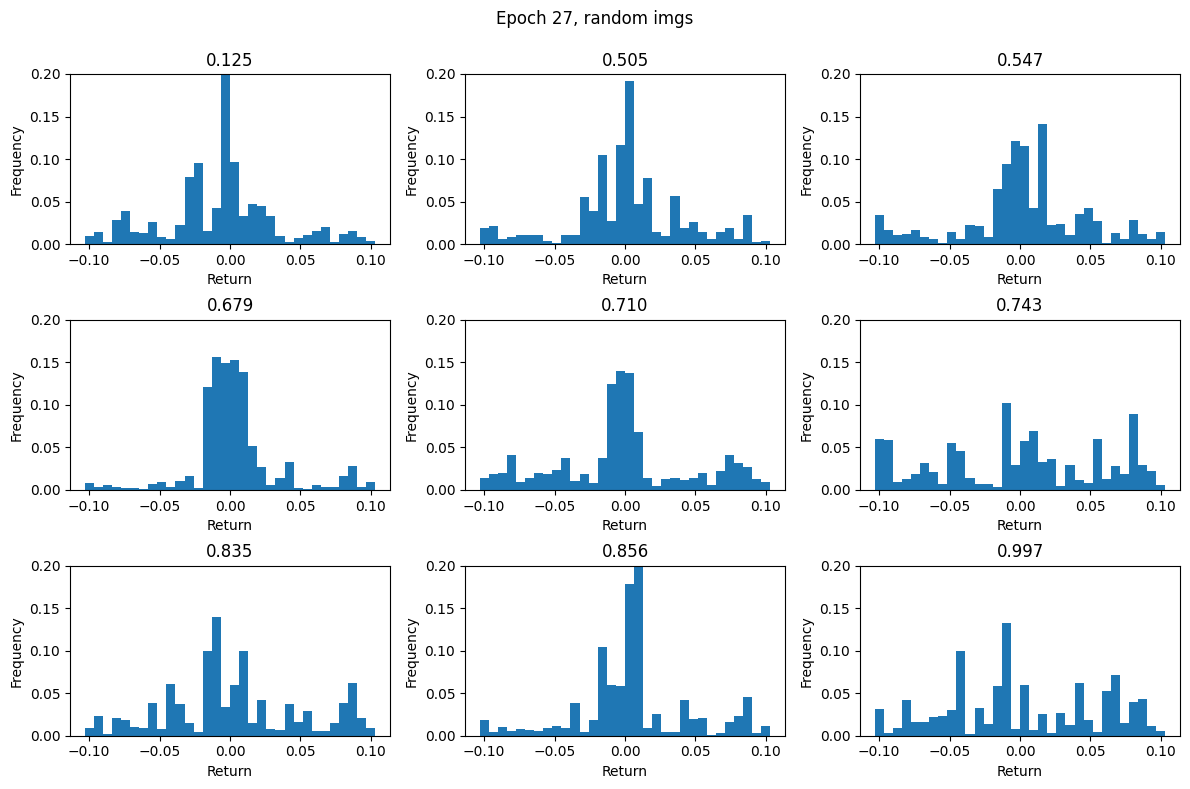

<Figure size 1000x400 with 0 Axes>

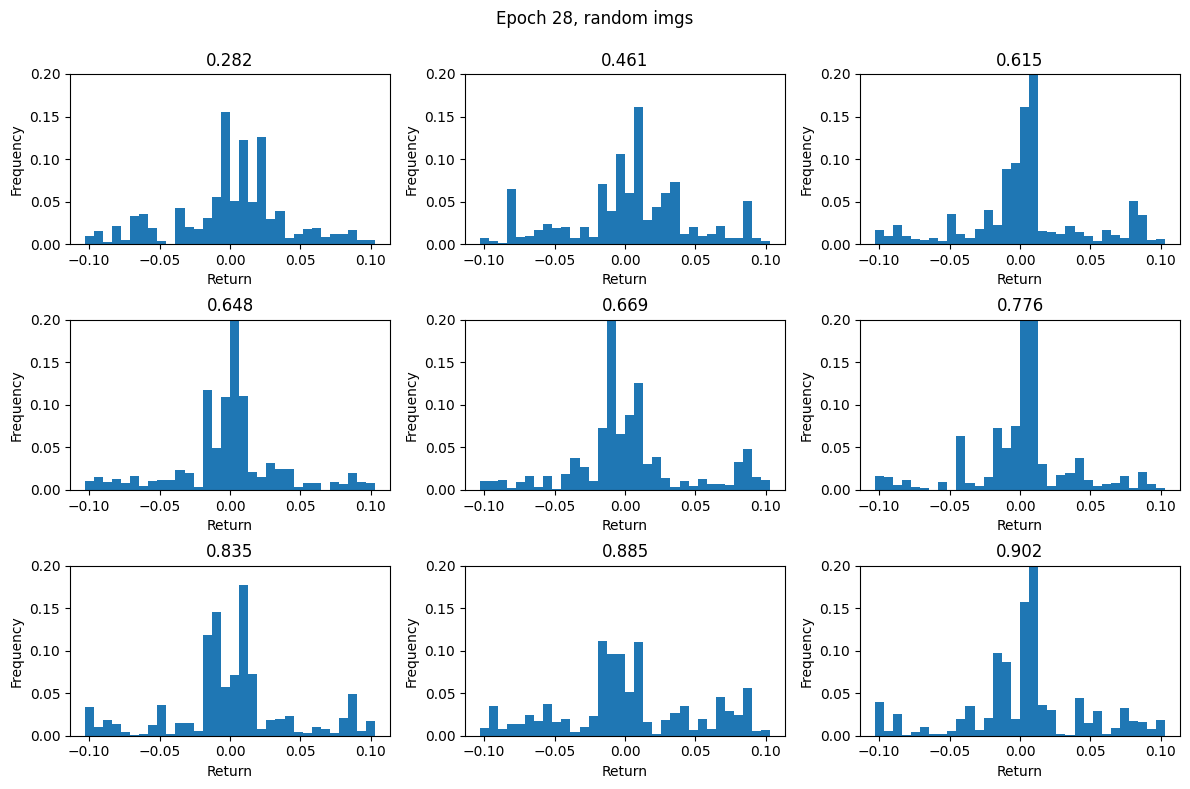

<Figure size 1000x400 with 0 Axes>

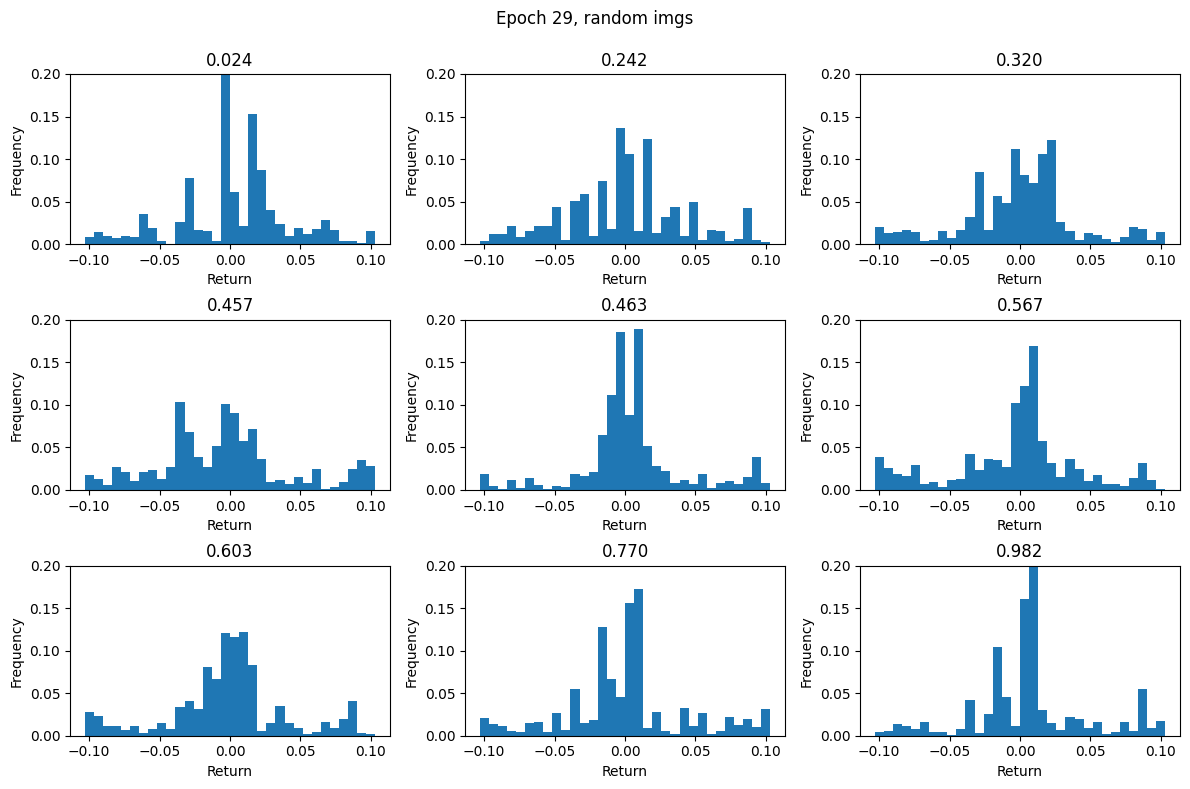

<Figure size 1000x400 with 0 Axes>

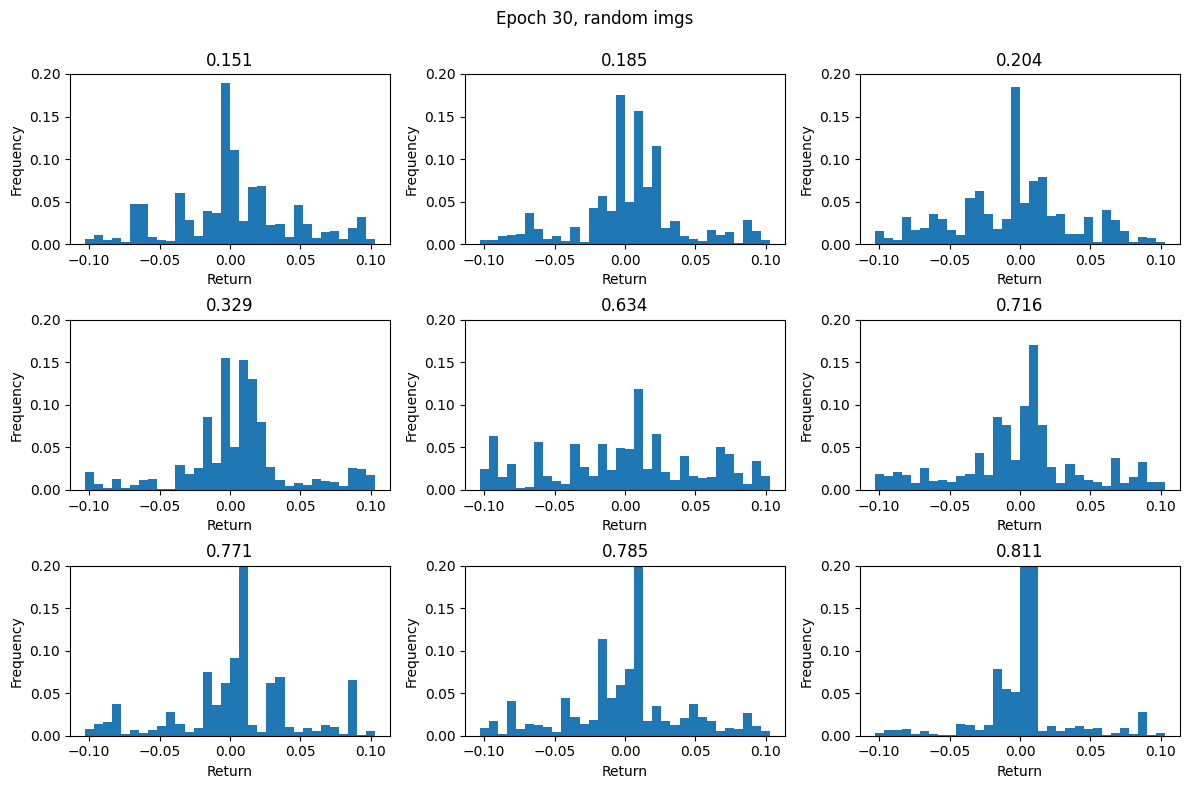

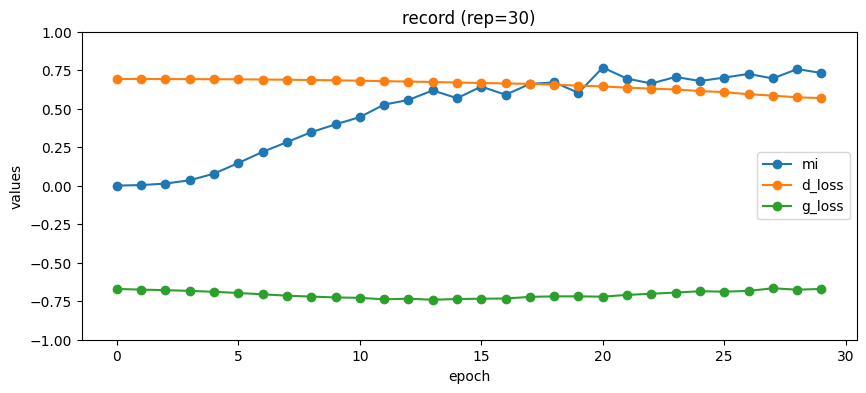

100%|██████████| 31/31 [01:22<00:00,  2.65s/it, G_loss=-.643, D_loss=0.549, MI=0.722]


epoch: 31, D_loss: 0.5487583587246556, G_loss: -0.6430542046023954, MI = 0.722143562570695


100%|██████████| 31/31 [01:18<00:00,  2.53s/it, G_loss=-.644, D_loss=0.543, MI=0.807]


epoch: 32, D_loss: 0.5427481378278425, G_loss: -0.6438814997673035, MI = 0.8067422499579768


100%|██████████| 31/31 [01:18<00:00,  2.54s/it, G_loss=-.643, D_loss=0.543, MI=0.791]


epoch: 33, D_loss: 0.5434753798669384, G_loss: -0.6433893999745769, MI = 0.791075603615853


100%|██████████| 31/31 [01:19<00:00,  2.58s/it, G_loss=-.625, D_loss=0.536, MI=0.758]


epoch: 34, D_loss: 0.5356817024369394, G_loss: -0.6249919918275648, MI = 0.7584236841047963


100%|██████████| 31/31 [01:17<00:00,  2.50s/it, G_loss=-.647, D_loss=0.53, MI=0.821] 


epoch: 35, D_loss: 0.5297843035190336, G_loss: -0.6468111641945378, MI = 0.8206786782510819


<Figure size 640x480 with 0 Axes>

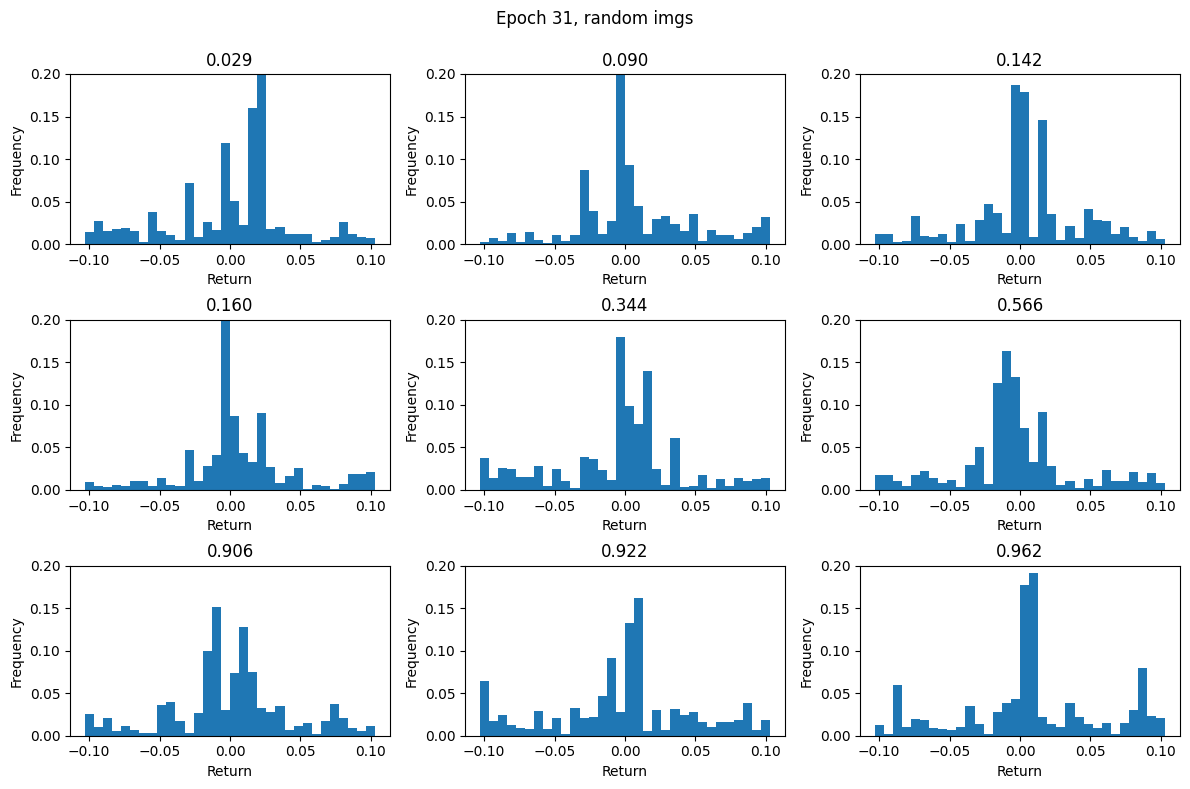

<Figure size 1000x400 with 0 Axes>

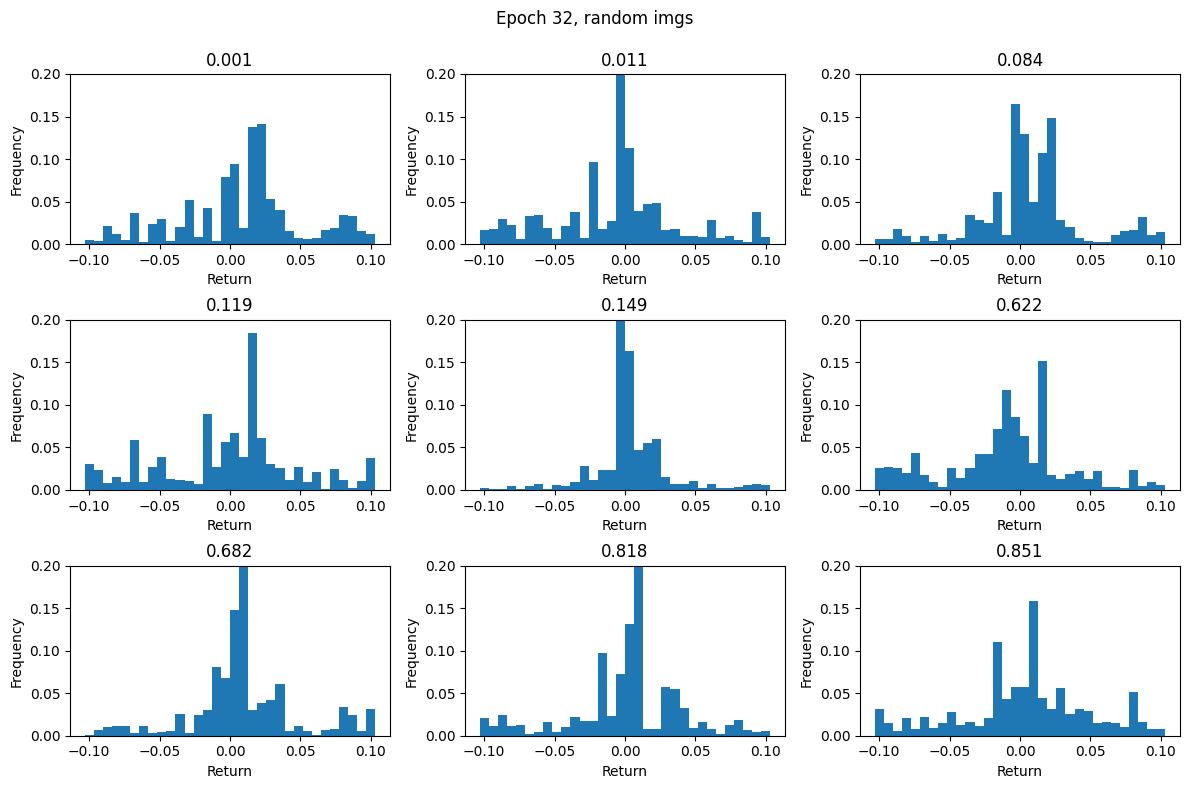

<Figure size 1000x400 with 0 Axes>

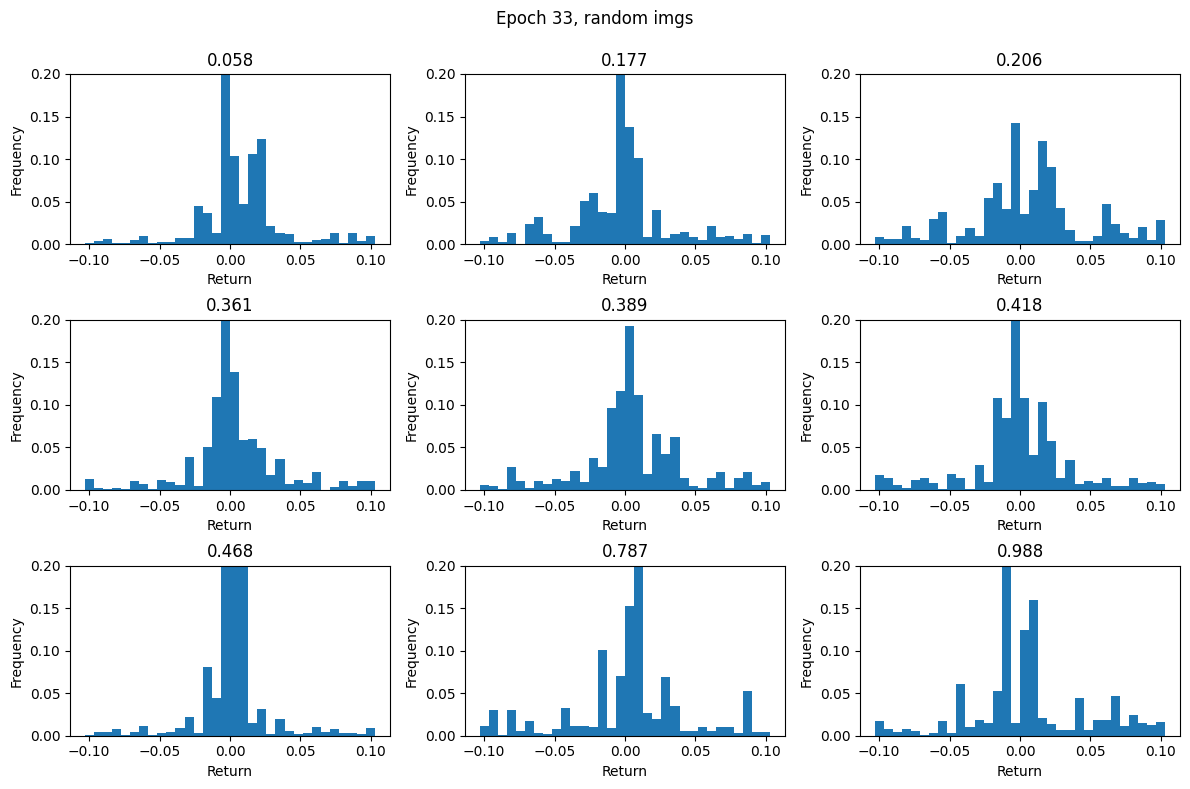

<Figure size 1000x400 with 0 Axes>

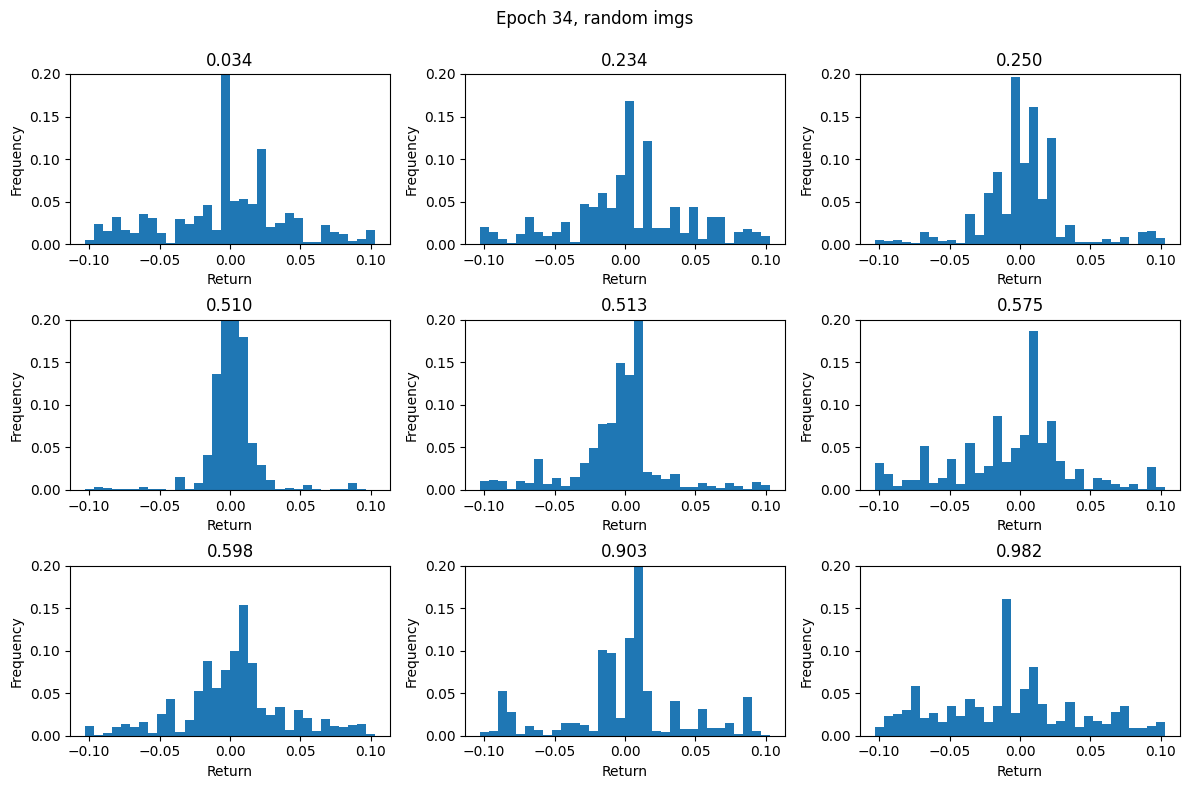

<Figure size 1000x400 with 0 Axes>

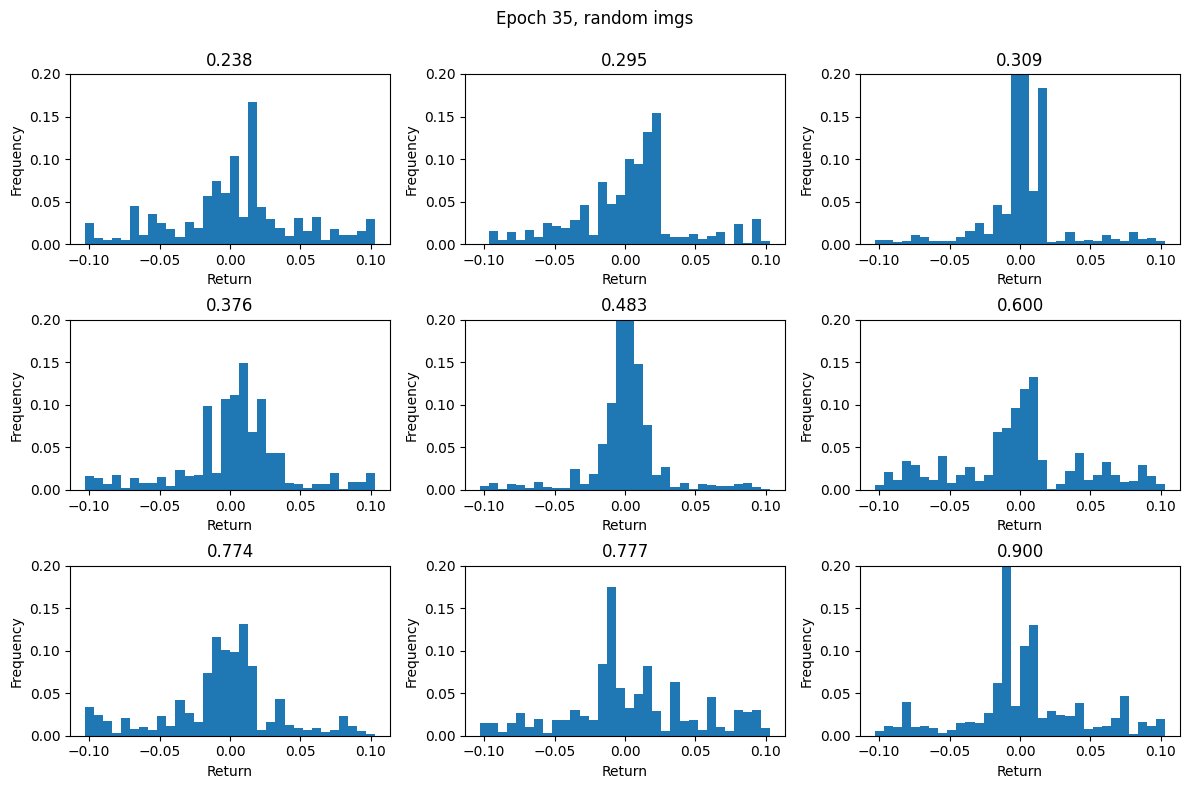

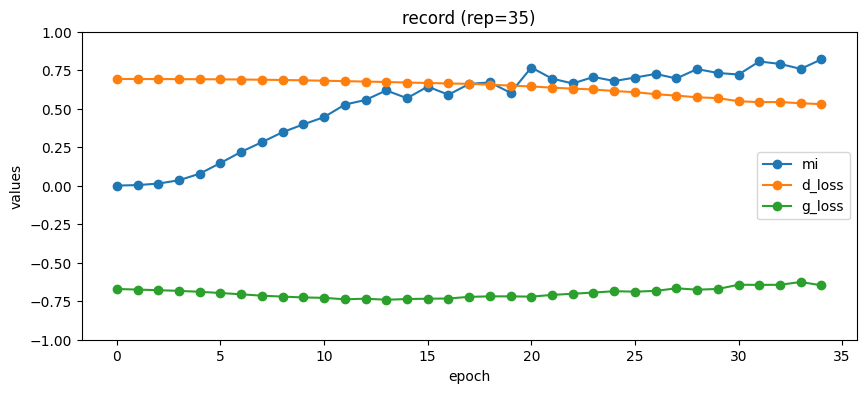

100%|██████████| 31/31 [01:17<00:00,  2.49s/it, G_loss=-.61, D_loss=0.515, MI=0.761] 


epoch: 36, D_loss: 0.514772976598432, G_loss: -0.6104861267151371, MI = 0.7613136652977236


100%|██████████| 31/31 [01:22<00:00,  2.66s/it, G_loss=-.609, D_loss=0.508, MI=0.762]


epoch: 37, D_loss: 0.507720660778784, G_loss: -0.6091841699615601, MI = 0.7623661968015856


100%|██████████| 31/31 [01:19<00:00,  2.58s/it, G_loss=-.608, D_loss=0.501, MI=0.79] 


epoch: 38, D_loss: 0.5009741667778261, G_loss: -0.6079272839330858, MI = 0.790050845953726


100%|██████████| 31/31 [01:19<00:00,  2.56s/it, G_loss=-.616, D_loss=0.501, MI=0.864]


epoch: 39, D_loss: 0.5008841397300843, G_loss: -0.6155577167387931, MI = 0.8635354907281937


100%|██████████| 31/31 [01:18<00:00,  2.54s/it, G_loss=-.594, D_loss=0.489, MI=0.74] 


epoch: 40, D_loss: 0.4886752616974615, G_loss: -0.5937494376013356, MI = 0.7401359811905892


<Figure size 640x480 with 0 Axes>

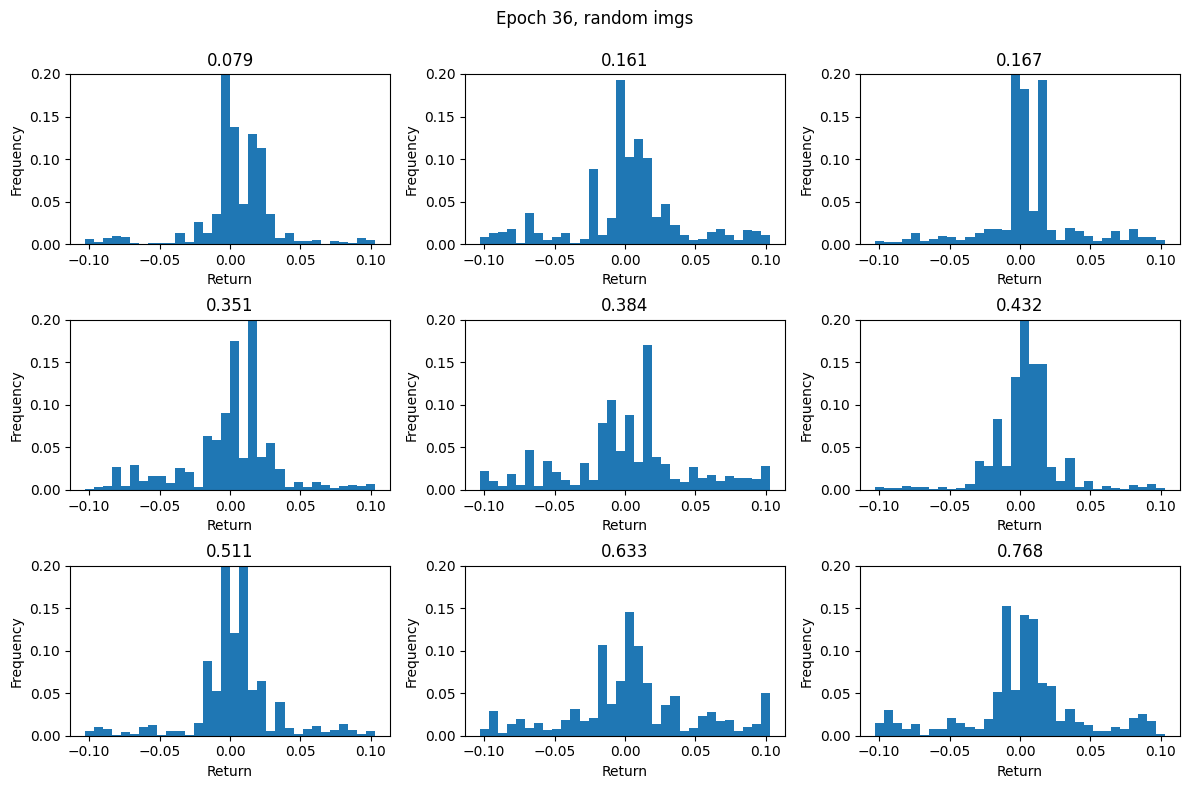

<Figure size 1000x400 with 0 Axes>

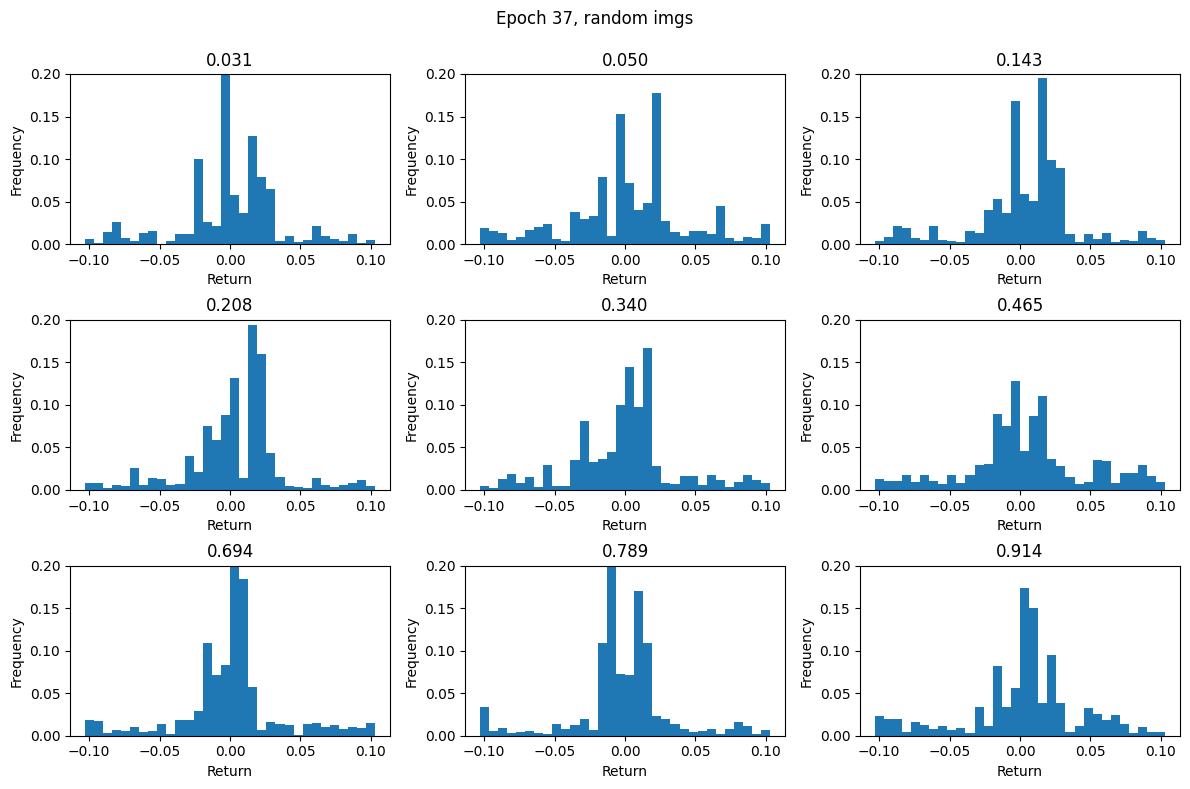

<Figure size 1000x400 with 0 Axes>

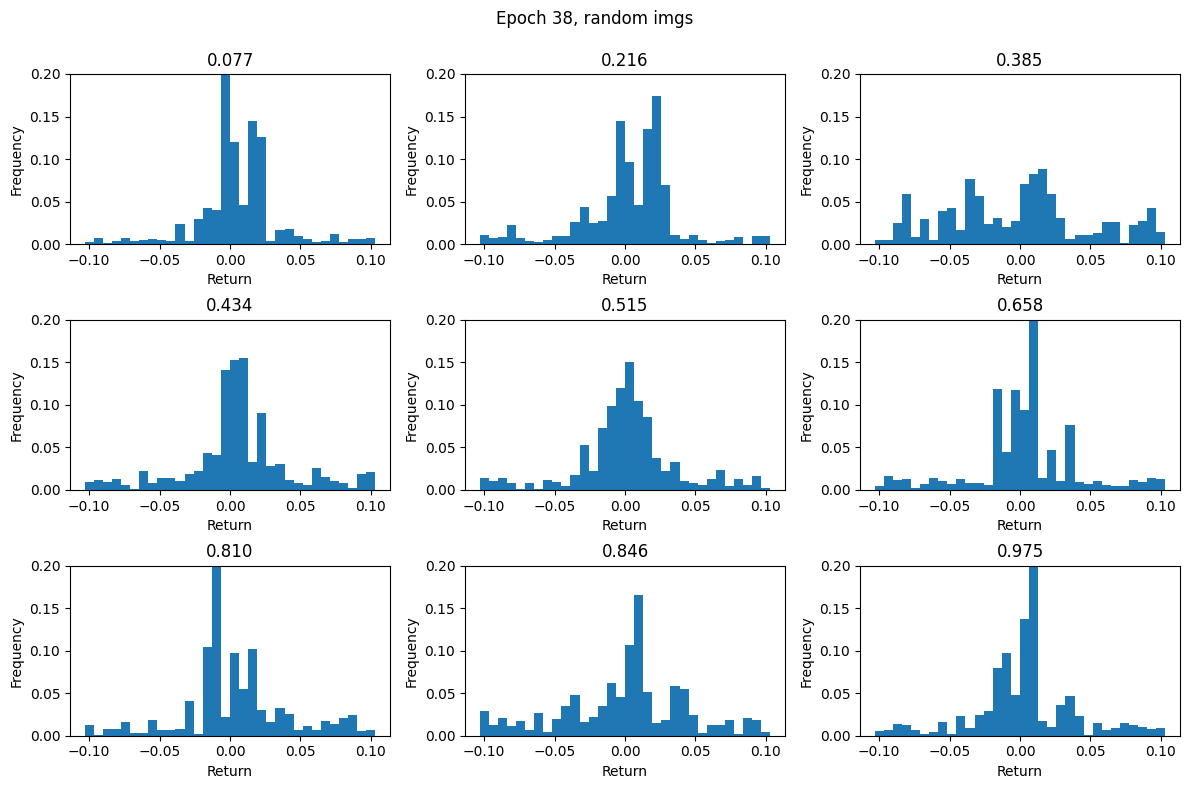

<Figure size 1000x400 with 0 Axes>

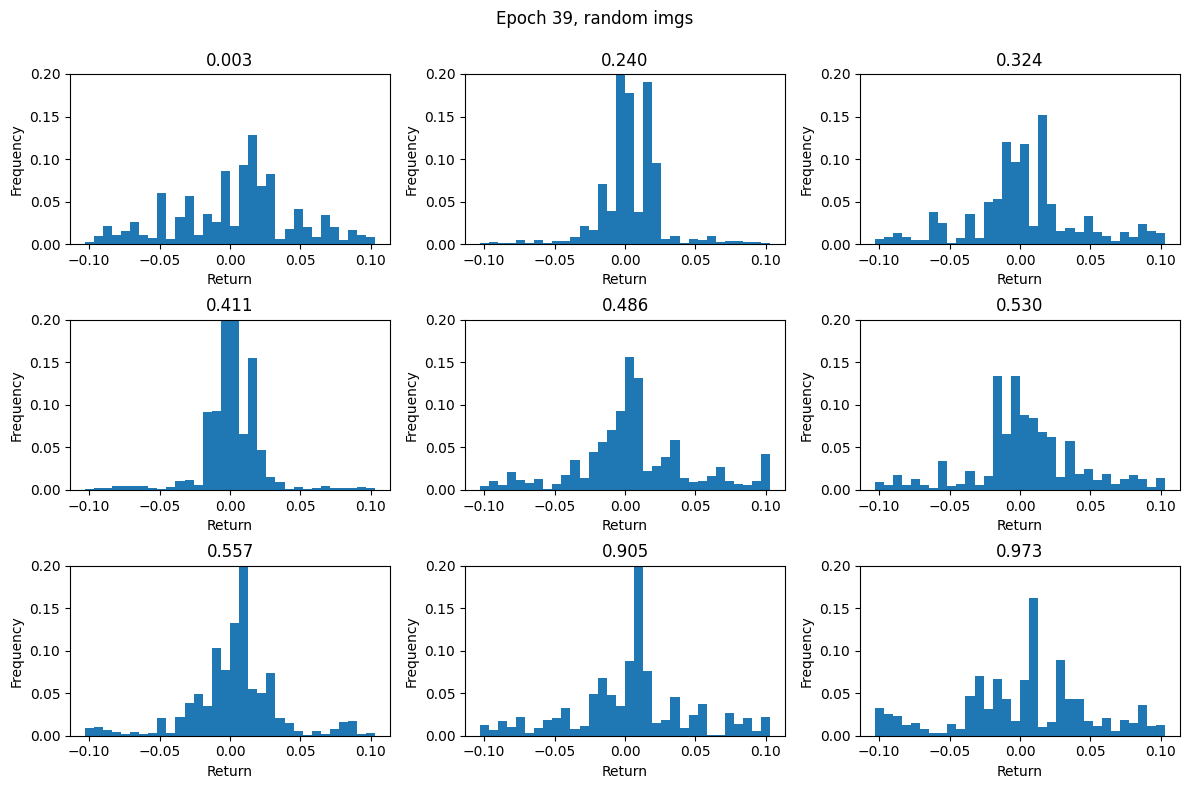

<Figure size 1000x400 with 0 Axes>

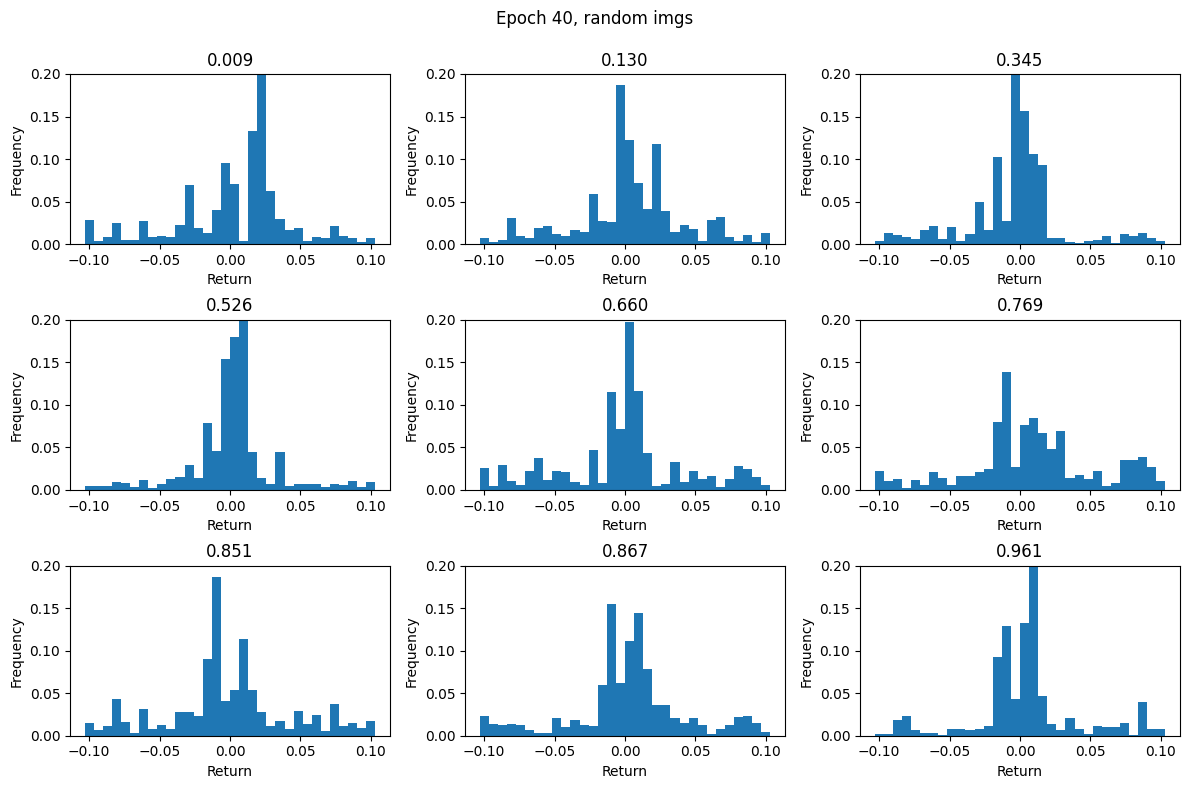

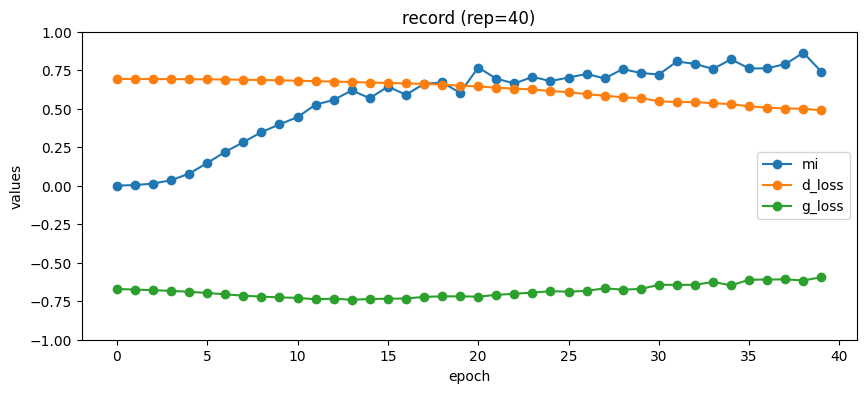

100%|██████████| 31/31 [01:20<00:00,  2.58s/it, G_loss=-.593, D_loss=0.485, MI=0.809]


epoch: 41, D_loss: 0.4846679010698872, G_loss: -0.5928487037458727, MI = 0.8085512268927789


 23%|██▎       | 7/31 [00:19<01:05,  2.73s/it, G_loss=-.55, D_loss=0.474, MI=0.655] 

In [226]:
import openpyxl
epoch = 1500

recorder_keywords = ['d_loss', 'g_loss', 'mi']
recorder = {k: [] for k in recorder_keywords}
final_rep = 0

for rep in range(1, epoch+1):
    np.random.shuffle(dataset)
    iter_num = int(len(dataset) * 0.25 //BATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.

    G_loss_sum = 0.0
    D_loss_sum = 0.0
    mi_sum = 0.0

    log_gen_outputs = []
    log_gen_codes = []
    pbar = tqdm(range(iter_num))

    for i in pbar:
        batch = torch.FloatTensor(dataset[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])

        # train generator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits))
        generator_output, generator_loss = generator_train_step(generator_params, generator_seed, use_mine=use_mine)
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()

        # train discriminator
        fake_input = generator_output.detach().to(torch.float32)
        disc_loss = disc_cost_fn(batch, fake_input, smoothing=False)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()

        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_outputs.append(fake_input.numpy())
        log_gen_codes.append(code_input.numpy())

    G_scheduler.step()
    D_scheduler.step()
    M_scheduler.step()

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss_sum/iter_num)
    recorder['mi'].append(mi_sum/iter_num)

    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num, mi_sum/iter_num))
    
    log_gen_outputs = np.concatenate(log_gen_outputs, axis=0)
    log_gen_codes = np.concatenate(log_gen_codes, axis=0)
    visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder)

    with open(f'result/{title}/discriminator_{rep}.pkl', 'wb') as file:
        pickle.dump(discriminator, file)
    with open(f'result/{title}/generator_{rep}.pkl', 'wb') as file:
        pickle.dump(generator_params, file)

    df = pd.DataFrame(recorder)
    output_filename = f'result/{title}/recorder.xlsx'
    df.to_excel(output_filename, index=False)

    final_rep = rep

In [ ]:
gen_outputs[:,0].mean()

## 모든 지표 엑셀파일로 저장

In [ ]:
import openpyxl
df = pd.DataFrame(recorder)
output_filename = f'result/{title}/recorder.xlsx'
df.to_excel(output_filesname, index=False)

## 최종 결과 plot

In [ ]:
inputs = []
outputs = []

for i in tqdm(range(5000)):
    with torch.no_grad():
        z = np.random.uniform(-1, 1, (1, n_qubits, 1))
        code_input = z[:, -code_qubits:].reshape(code_qubits) # 입력 z중에서 code를 추출한다.
        generator_output = generator_forward(generator_params, z, copula=output_copula)
        generator_output = generator_output.cpu().numpy().reshape(2)
        outputs.append(generator_output)
        inputs.append(code_input)

inputs = np.array(inputs).reshape(-1, code_qubits)

for code_ind in range(code_qubits):
    outputs = np.array(outputs)
    plt.scatter(outputs[:, 0], outputs[:, 1], c=inputs[:, code_ind], cmap='RdYlBu', alpha=0.2)
    plt.colorbar()  # 색상 막대 추가
    plt.title(f'code{code_ind}-distribution (rep = {final_rep})')
    plt.savefig(f'result/{title}/code_{code_ind}_{final_rep}.png')
    plt.show()